## Reconnaissance de Caractères Isolés (ICR)

In [1]:
!nvidia-smi

Sat Dec 13 23:46:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1. Configuration de l'Environnement et Installation des Dépendances

**Théorie :** La mise en place d'un environnement de développement robuste est essentielle pour garantir la reproductibilité et l'efficacité du pipeline ML. Nous installons les bibliothèques nécessaires pour le téléchargement de datasets, la manipulation de données, et la visualisation.

In [2]:
# Installation des bibliothèques nécessaires
%pip install -q kagglehub torchvision seaborn scikit-learn

In [3]:
# Importations standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration pour des graphiques professionnels
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ Environnement configuré avec succès")

✓ Environnement configuré avec succès


**Explication Technique :**
- Installation silencieuse (`-q`) pour éviter les sorties volumineuses
- `kagglehub` : interface moderne pour télécharger des datasets Kaggle
- `torchvision` : framework PyTorch pour les datasets de vision par ordinateur
- Configuration de `matplotlib` et `seaborn` pour des visualisations académiques
- Suppression des avertissements pour une sortie propre

---

### 2. Chargement du Dataset A-Z Handwritten Alphabets

**Théorie :** Le dataset A-Z contient des images de lettres manuscrites (A-Z) au format 28x28 pixels, similaire à MNIST mais pour l'alphabet latin. L'optimisation mémoire commence dès le chargement : utiliser `uint8` (1 octet par pixel) au lieu de `float64` (8 octets) réduit l'empreinte mémoire de 87.5%. Sur un GPU T4 avec 16 GB de RAM, cette optimisation est cruciale pour traiter de grands volumes de données.

In [5]:
import kagglehub

# Téléchargement du dataset A-Z via kagglehub
print("Téléchargement du dataset A-Z Handwritten Alphabets...")
path_az = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")
print(f"Dataset téléchargé dans : {path_az}")

# Chargement optimisé avec dtype spécifié
import os
csv_files = [f for f in os.listdir(path_az) if f.endswith('.csv')]
print(f"Fichiers CSV trouvés : {csv_files}")

# Chargement du fichier principal avec optimisation mémoire
csv_path = os.path.join(path_az, csv_files[0])
df_az = pd.read_csv(csv_path, dtype=np.uint8)

print(f"\nDataset A-Z chargé avec succès")
print(f"Forme du dataset : {df_az.shape}")
print(f"Taille mémoire : {df_az.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Téléchargement du dataset A-Z Handwritten Alphabets...
Using Colab cache for faster access to the 'az-handwritten-alphabets-in-csv-format' dataset.
Dataset téléchargé dans : /kaggle/input/az-handwritten-alphabets-in-csv-format
Fichiers CSV trouvés : ['A_Z Handwritten Data.csv']

Dataset A-Z chargé avec succès
Forme du dataset : (372450, 785)
Taille mémoire : 278.83 MB


**Explication Technique :**
1. `kagglehub.dataset_download()` : télécharge le dataset et retourne le chemin local
2. `dtype=np.uint8` : force pandas à stocker les valeurs en entiers non signés 8 bits (0-255), optimisation critique
3. Recherche automatique des fichiers CSV dans le répertoire téléchargé
4. `memory_usage(deep=True)` : calcule l'empreinte mémoire réelle incluant les index et métadonnées
5. Division par `1024**2` pour conversion octets → mégaoctets

---

### 3. Exploration du Dataset A-Z (Analyse Pré-Fusion)

**Théorie :** L'analyse exploratoire des données (EDA) permet d'identifier les déséquilibres de classes, les anomalies et la qualité des données avant toute transformation. Pour les modèles de classification, comprendre la distribution des classes est essentiel car un déséquilibre significatif peut biaiser l'apprentissage vers les classes majoritaires.

In [6]:
# Analyse de la structure du dataset A-Z
print("="*60)
print("ANALYSE DU DATASET A-Z HANDWRITTEN ALPHABETS")
print("="*60)

# Affichage des premières lignes
print("\nAperçu des données :")
print(df_az.head())

# Dimensions et structure
print(f"\nDimensions : {df_az.shape[0]} échantillons × {df_az.shape[1]} features")
print(f"Colonnes : {df_az.columns.tolist()[:5]} ... (total: {len(df_az.columns)})")

# Séparation labels et pixels
az_labels = df_az.iloc[:, 0].values  # Première colonne = labels
az_pixels = df_az.iloc[:, 1:].values  # Colonnes restantes = pixels

print(f"\nForme des labels : {az_labels.shape}")
print(f"Forme des pixels : {az_pixels.shape}")
print(f"Valeurs des pixels : min={az_pixels.min()}, max={az_pixels.max()}")

# Distribution des classes
print("\nDistribution des classes (A=0, B=1, ..., Z=25) :")
label_counts = Counter(az_labels)
for label in sorted(label_counts.keys())[:5]:  # Afficher les 5 premières
    char = chr(65 + label)  # Conversion en lettre
    print(f"  Classe {label} ({char}) : {label_counts[label]:,} échantillons")

ANALYSE DU DATASET A-Z HANDWRITTEN ALPHABETS

Aperçu des données :
   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.639  0.640  0.641  \
0  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.642  0.643  0.644  0.645  0.646  0.647  0.648  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

Dimensions : 372450 échantillons × 785 features
Colonnes : ['0', '0.1', '0.2', '0.3', '0.4'] ... (total: 785)

Form

**Explication Technique :**
1. `iloc[:, 0]` : sélection vectorisée de la colonne des labels (indice 0)
2. `iloc[:, 1:]` : sélection vectorisée de toutes les colonnes de pixels (784 features pour 28×28)
3. `.values` : conversion en array NumPy pour des opérations matricielles rapides
4. `Counter()` : comptage efficace des occurrences en O(n)
5. `chr(65 + label)` : conversion ASCII (65='A') pour afficher les lettres correspondantes

**Pourquoi cette Visualisation :** La distribution des classes révèle si le dataset est équilibré. Un déséquilibre peut nécessiter des techniques de rééchantillonnage ou de pondération des classes durant l'entraînement.

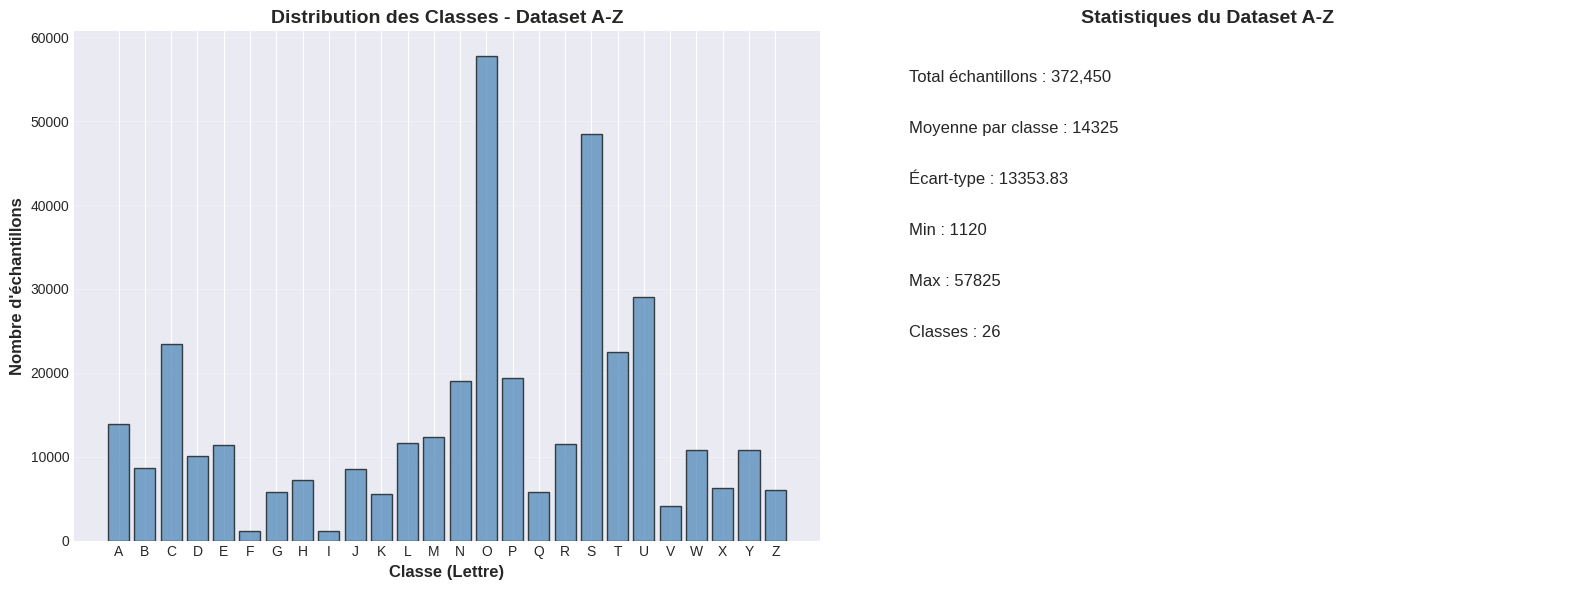


Coefficient de variation : 93.22%
→ Déséquilibre significatif - techniques de rééquilibrage recommandées


In [7]:
# Visualisation de la distribution des classes A-Z
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Distribution par classe
labels_sorted = sorted(label_counts.keys())
counts = [label_counts[l] for l in labels_sorted]
letters = [chr(65 + l) for l in labels_sorted]

axes[0].bar(letters, counts, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Classe (Lettre)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre d\'échantillons', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution des Classes - Dataset A-Z', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

# Graphique 2 : Statistiques descriptives
stats = pd.Series(counts)
axes[1].text(0.1, 0.9, f"Total échantillons : {stats.sum():,}", fontsize=12, transform=axes[1].transAxes)
axes[1].text(0.1, 0.8, f"Moyenne par classe : {stats.mean():.0f}", fontsize=12, transform=axes[1].transAxes)
axes[1].text(0.1, 0.7, f"Écart-type : {stats.std():.2f}", fontsize=12, transform=axes[1].transAxes)
axes[1].text(0.1, 0.6, f"Min : {stats.min()}", fontsize=12, transform=axes[1].transAxes)
axes[1].text(0.1, 0.5, f"Max : {stats.max()}", fontsize=12, transform=axes[1].transAxes)
axes[1].text(0.1, 0.4, f"Classes : {len(labels_sorted)}", fontsize=12, transform=axes[1].transAxes)
axes[1].axis('off')
axes[1].set_title('Statistiques du Dataset A-Z', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calcul du coefficient de variation (mesure du déséquilibre)
cv = (stats.std() / stats.mean()) * 100
print(f"\nCoefficient de variation : {cv:.2f}%")
if cv < 10:
    print("→ Dataset bien équilibré")
elif cv < 30:
    print("→ Déséquilibre modéré")
else:
    print("→ Déséquilibre significatif - techniques de rééquilibrage recommandées")

**Explication Technique :**
1. `plt.subplots(1, 2)` : création d'une grille 1×2 pour comparer visuellement
2. List comprehension `[chr(65 + l) for l in labels_sorted]` : vectorisation pour conversion ASCII
3. `edgecolor='black'` : contours pour améliorer la lisibilité académique
4. `transAxes` : coordonnées relatives (0-1) pour placement de texte indépendant des données
5. Coefficient de variation (CV) : mesure standardisée du déséquilibre, défini comme σ/μ × 100

**Pourquoi Visualiser les Images :** Vérifier visuellement la qualité des données (bruit, orientation, contraste) et confirmer que le reshape 784→28×28 préserve la structure spatiale des caractères.

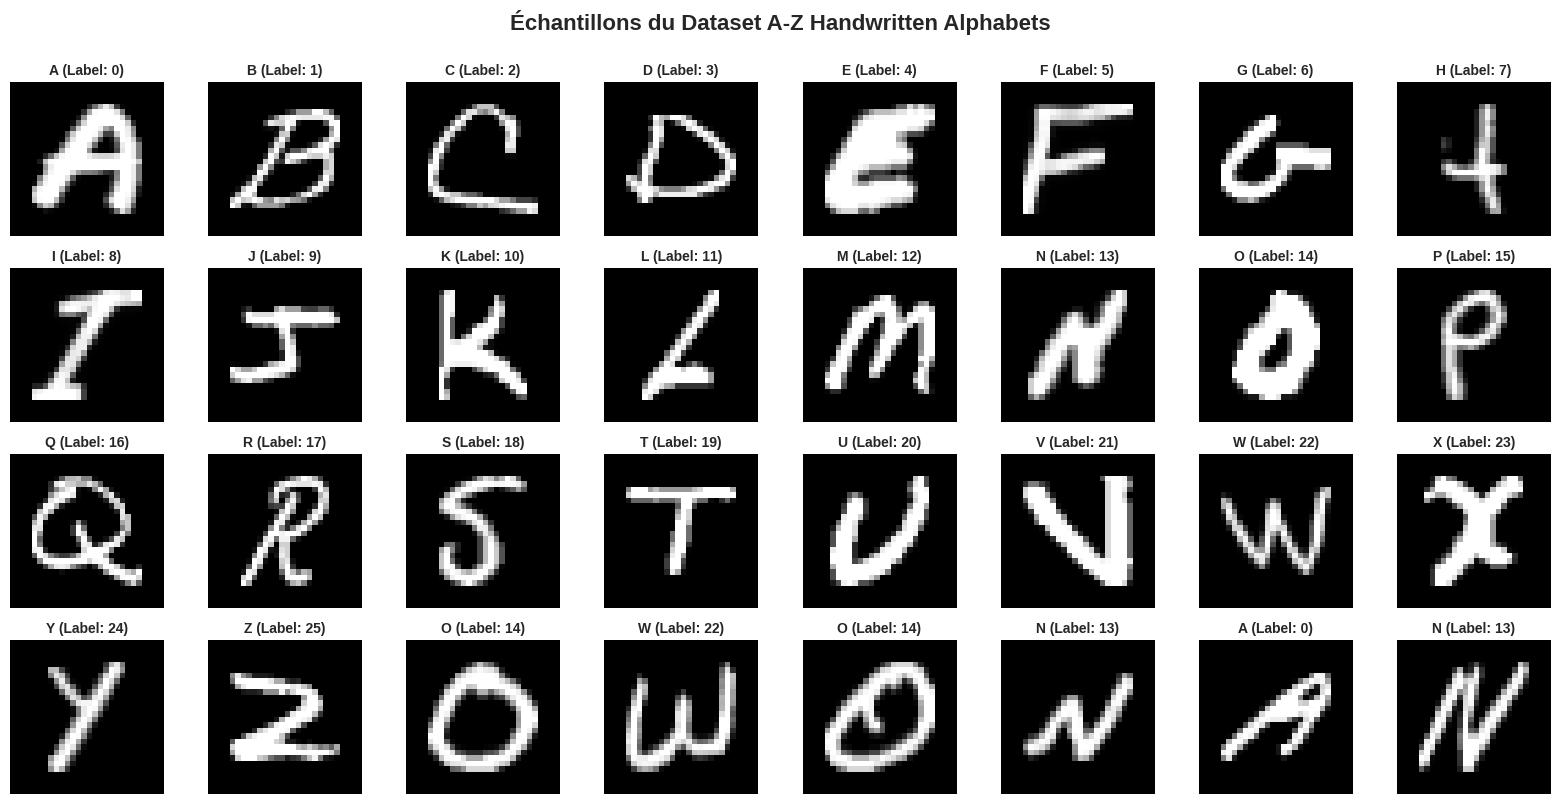


Reshape vérifié : 784 pixels → 28×28 matrice
Échantillon de pixels bruts (vecteur) : [0 0 0 0 0 0 0 0 0 0]...
Après reshape en 28×28, première ligne : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# Visualisation d'échantillons d'images manuscrites A-Z
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Échantillons du Dataset A-Z Handwritten Alphabets', fontsize=16, fontweight='bold', y=1.00)

# Sélection d'échantillons aléatoires stratifiés (un par classe + extras)
np.random.seed(42)
sample_indices = []
for label in range(26):  # A-Z
    indices = np.where(az_labels == label)[0]
    sample_indices.append(np.random.choice(indices))

# Compléter avec des échantillons aléatoires pour remplir la grille 4×8=32
while len(sample_indices) < 32:
    sample_indices.append(np.random.randint(0, len(az_labels)))

# Affichage des images
for idx, ax in enumerate(axes.flat):
    if idx < len(sample_indices):
        sample_idx = sample_indices[idx]
        # Reshape du vecteur 784 en matrice 28×28
        image = az_pixels[sample_idx].reshape(28, 28)
        label = az_labels[sample_idx]
        letter = chr(65 + label)

        ax.imshow(image, cmap='gray', interpolation='nearest')
        ax.set_title(f'{letter} (Label: {label})', fontsize=10, fontweight='bold')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nReshape vérifié : 784 pixels → 28×28 matrice")
print(f"Échantillon de pixels bruts (vecteur) : {az_pixels[0][:10]}...")
print(f"Après reshape en 28×28, première ligne : {az_pixels[0].reshape(28, 28)[0]}")

**Explication Technique :**
1. `np.random.seed(42)` : reproductibilité des résultats
2. `np.where(az_labels == label)[0]` : recherche vectorisée des indices, O(n) mais optimisé en C
3. `.reshape(28, 28)` : réorganisation du vecteur en matrice sans copie mémoire (vue)
4. `cmap='gray'` : colormap pour images en niveaux de gris
5. `interpolation='nearest'` : pas de lissage pour préserver les pixels bruts
6. Échantillonnage stratifié garantit la représentativité de toutes les classes

---

### 4. Chargement du Dataset EMNIST

**Théorie :** EMNIST (Extended MNIST) est une extension de MNIST qui inclut des lettres en plus des chiffres. Nous utilisons `torchvision` car il fournit une interface optimisée avec téléchargement automatique, décompression et chargement en mémoire efficace. Le split 'letters' contient 26 classes (A-Z) avec plus de 100,000 échantillons d'entraînement.

In [9]:
from torchvision import datasets, transforms
import torch

# Téléchargement et chargement du dataset EMNIST
print("Téléchargement du dataset EMNIST (Letters)...")
emnist_train = datasets.EMNIST(
    root='./data',
    split='letters',
    train=True,
    download=True,
    transform=None  # Pas de transformation pour garder les données brutes
)

emnist_test = datasets.EMNIST(
    root='./data',
    split='letters',
    train=False,
    download=True,
    transform=None
)

print(f"\nEMNIST Train : {len(emnist_train)} échantillons")
print(f"EMNIST Test : {len(emnist_test)} échantillons")

# Conversion en arrays NumPy pour uniformité avec A-Z dataset
# EMNIST retourne des PIL Images, on les convertit en arrays
emnist_train_images = []
emnist_train_labels = []

print("\nConversion des données EMNIST en arrays NumPy...")
for idx in range(len(emnist_train)):
    img, label = emnist_train[idx]
    # Conversion PIL → NumPy array, puis aplatissement 28×28 → 784
    img_array = np.array(img, dtype=np.uint8).flatten()
    emnist_train_images.append(img_array)
    emnist_train_labels.append(label - 1)  # EMNIST: labels 1-26, on normalise à 0-25

# Conversion en arrays NumPy optimisés
emnist_pixels = np.array(emnist_train_images, dtype=np.uint8)
emnist_labels = np.array(emnist_train_labels, dtype=np.uint8)

print(f"\nConversion terminée")
print(f"Forme des pixels EMNIST : {emnist_pixels.shape}")
print(f"Forme des labels EMNIST : {emnist_labels.shape}")
print(f"Taille mémoire : {(emnist_pixels.nbytes + emnist_labels.nbytes) / 1024**2:.2f} MB")

Téléchargement du dataset EMNIST (Letters)...


100%|██████████| 562M/562M [00:05<00:00, 103MB/s]



EMNIST Train : 124800 échantillons
EMNIST Test : 20800 échantillons

Conversion des données EMNIST en arrays NumPy...

Conversion terminée
Forme des pixels EMNIST : (124800, 784)
Forme des labels EMNIST : (124800,)
Taille mémoire : 93.43 MB


**Explication Technique :**
1. `split='letters'` : sélectionne uniquement les lettres A-Z (26 classes)
2. `train=True/False` : charge respectivement les sets d'entraînement et de test
3. `transform=None` : désactive les transformations PyTorch pour accéder aux données brutes
4. `.flatten()` : conversion 28×28 → 784 pour uniformité avec le dataset A-Z
5. `label - 1` : normalisation des labels EMNIST (1-26) vers (0-25) pour cohérence
6. `np.array()` avec `dtype=np.uint8` : conversion optimisée mémoire
7. Boucle Python nécessaire car EMNIST retourne des objets PIL individuels (pas de batch)

---

### 5. Exploration du Dataset EMNIST (Analyse Pré-Fusion)

**Théorie :** L'analyse comparative pré-fusion permet d'identifier les différences structurelles entre les datasets avant de les combiner. Cela inclut la distribution des classes, la qualité visuelle des images, et les statistiques de pixels qui peuvent révéler des différences de contraste ou de normalisation.

In [12]:
# Analyse du dataset EMNIST
print("="*60)
print("ANALYSE DU DATASET EMNIST (LETTERS)")
print("="*60)

print(f"\nDimensions : {emnist_pixels.shape[0]} échantillons × {emnist_pixels.shape[1]} features")
print(f"Forme des pixels : {emnist_pixels.shape}")
print(f"Valeurs des pixels : min={emnist_pixels.min()}, max={emnist_pixels.max()}")

# Distribution des classes
print("\nDistribution des classes EMNIST :")
emnist_label_counts = Counter(emnist_labels)
for label in sorted(emnist_label_counts.keys())[:5]:
    char = chr(65 + label)
    print(f"  Classe {label} ({char}) : {emnist_label_counts[label]:,} échantillons")

# Statistiques comparatives
print("\n" + "="*60)
print("COMPARAISON DES STATISTIQUES")
print("="*60)
print(f"\n{'Métrique':<30} {'A-Z Dataset':<20} {'EMNIST Dataset':<20}")
print("-"*70)
print(f"{'Nombre d\'échantillons':<30} {len(az_labels):<20,} {len(emnist_labels):<20,}")
print(f"{'Nombre de classes':<30} {len(set(az_labels)):<20} {len(set(emnist_labels)):<20}")
print(f"{'Dimension des images':<30} {'28×28 (784)':<20} {'28×28 (784)':<20}")
print(f"{'Type de données':<30} {az_pixels.dtype.name:<20} {emnist_pixels.dtype.name:<20}")
print(f"{'Taille mémoire (MB)':<30} {az_pixels.nbytes/1024**2:<20.2f} {emnist_pixels.nbytes/1024**2:<20.2f}")

ANALYSE DU DATASET EMNIST (LETTERS)

Dimensions : 124800 échantillons × 784 features
Forme des pixels : (124800, 784)
Valeurs des pixels : min=0, max=255

Distribution des classes EMNIST :
  Classe 0 (A) : 4,800 échantillons
  Classe 1 (B) : 4,800 échantillons
  Classe 2 (C) : 4,800 échantillons
  Classe 3 (D) : 4,800 échantillons
  Classe 4 (E) : 4,800 échantillons

COMPARAISON DES STATISTIQUES

Métrique                       A-Z Dataset          EMNIST Dataset      
----------------------------------------------------------------------
Nombre d'échantillons          372,450              124,800             
Nombre de classes              26                   26                  
Dimension des images           28×28 (784)          28×28 (784)         
Type de données                uint8                uint8               
Taille mémoire (MB)            278.47               93.31               


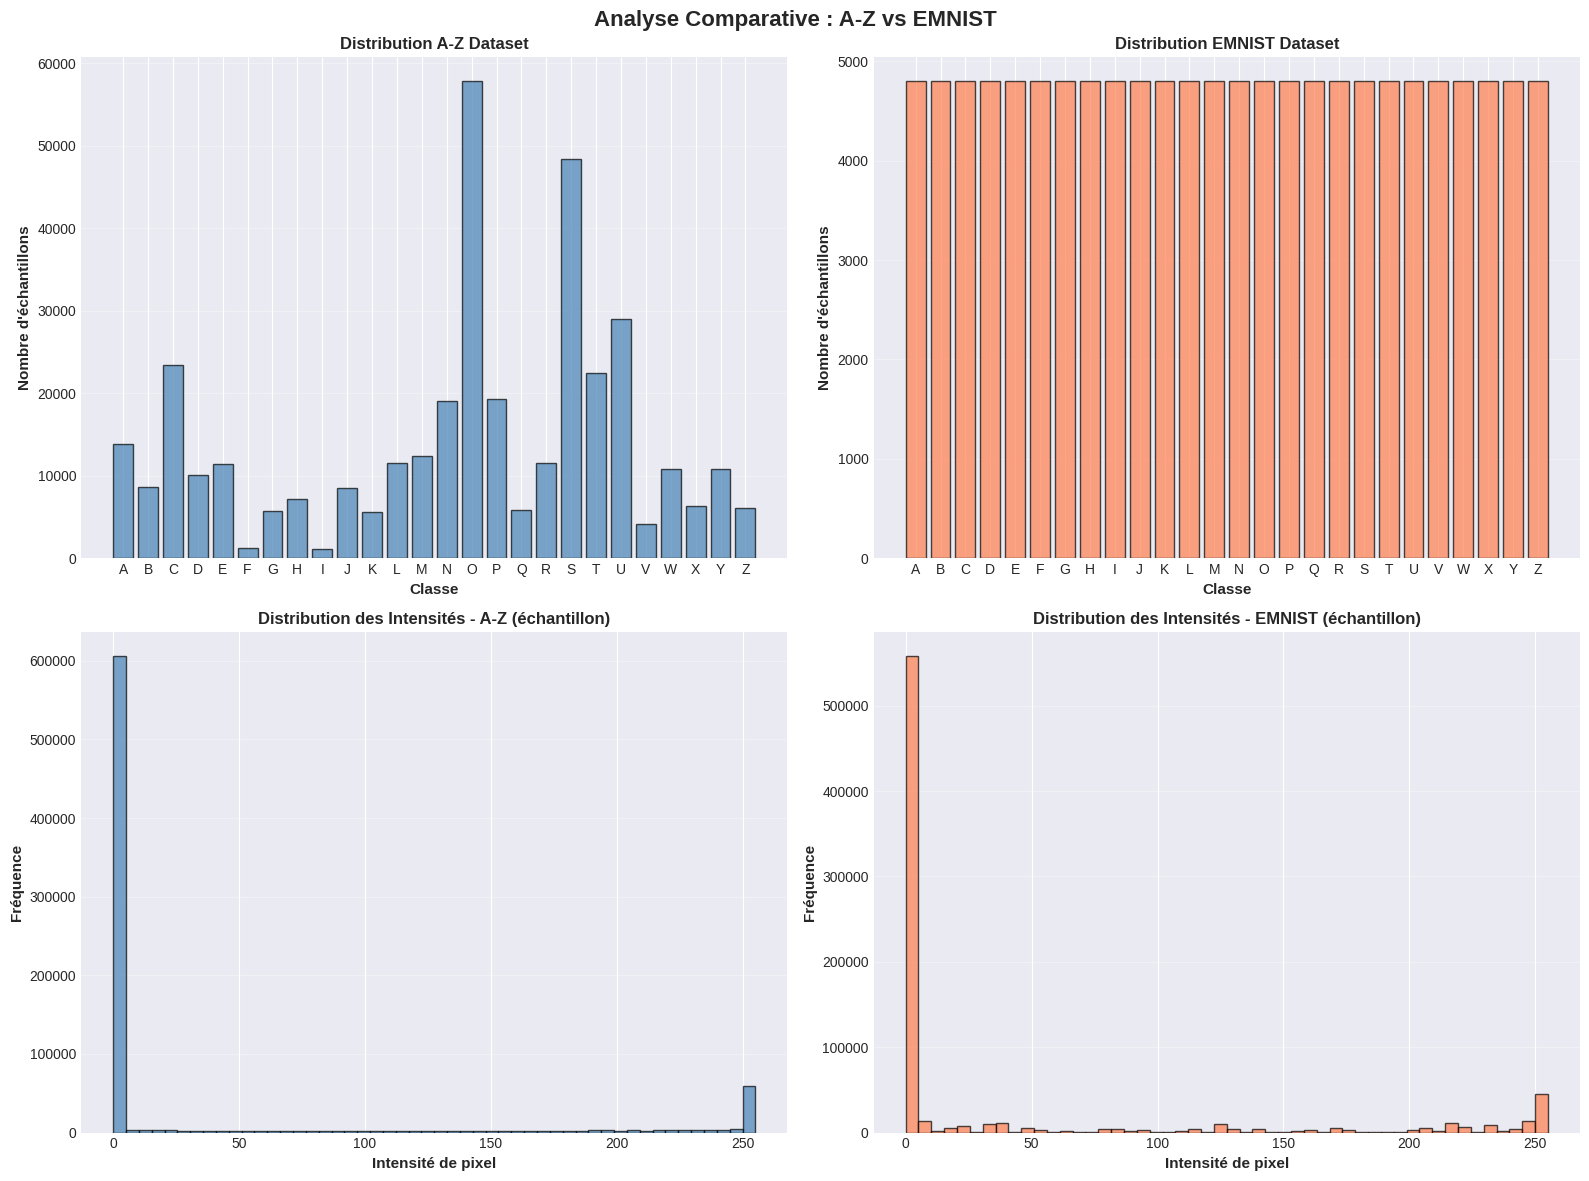

In [13]:
# Visualisation comparative des distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse Comparative : A-Z vs EMNIST', fontsize=16, fontweight='bold')

# Distribution A-Z
az_letters = [chr(65 + l) for l in sorted(label_counts.keys())]
az_counts = [label_counts[l] for l in sorted(label_counts.keys())]
axes[0, 0].bar(az_letters, az_counts, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Classe', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Nombre d\'échantillons', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution A-Z Dataset', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Distribution EMNIST
emnist_letters = [chr(65 + l) for l in sorted(emnist_label_counts.keys())]
emnist_counts = [emnist_label_counts[l] for l in sorted(emnist_label_counts.keys())]
axes[0, 1].bar(emnist_letters, emnist_counts, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Classe', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Nombre d\'échantillons', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution EMNIST Dataset', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Histogramme des intensités de pixels - A-Z
sample_az = az_pixels[np.random.choice(len(az_pixels), 1000, replace=False)].flatten()
axes[1, 0].hist(sample_az, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Intensité de pixel', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Distribution des Intensités - A-Z (échantillon)', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Histogramme des intensités de pixels - EMNIST
sample_emnist = emnist_pixels[np.random.choice(len(emnist_pixels), 1000, replace=False)].flatten()
axes[1, 1].hist(sample_emnist, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Intensité de pixel', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Distribution des Intensités - EMNIST (échantillon)', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Explication Technique :**
1. `np.random.choice(len(), 1000, replace=False)` : échantillonnage aléatoire sans remplacement pour éviter la surcharge mémoire
2. `.flatten()` : aplatissement de la matrice 1000×784 en vecteur pour l'histogramme
3. `bins=50` : discrétisation de l'espace 0-255 en 50 intervalles pour visualisation
4. Grille 2×2 permet la comparaison directe distribution de classes vs distribution de pixels
5. Les histogrammes de pixels révèlent le contraste et la normalisation des images

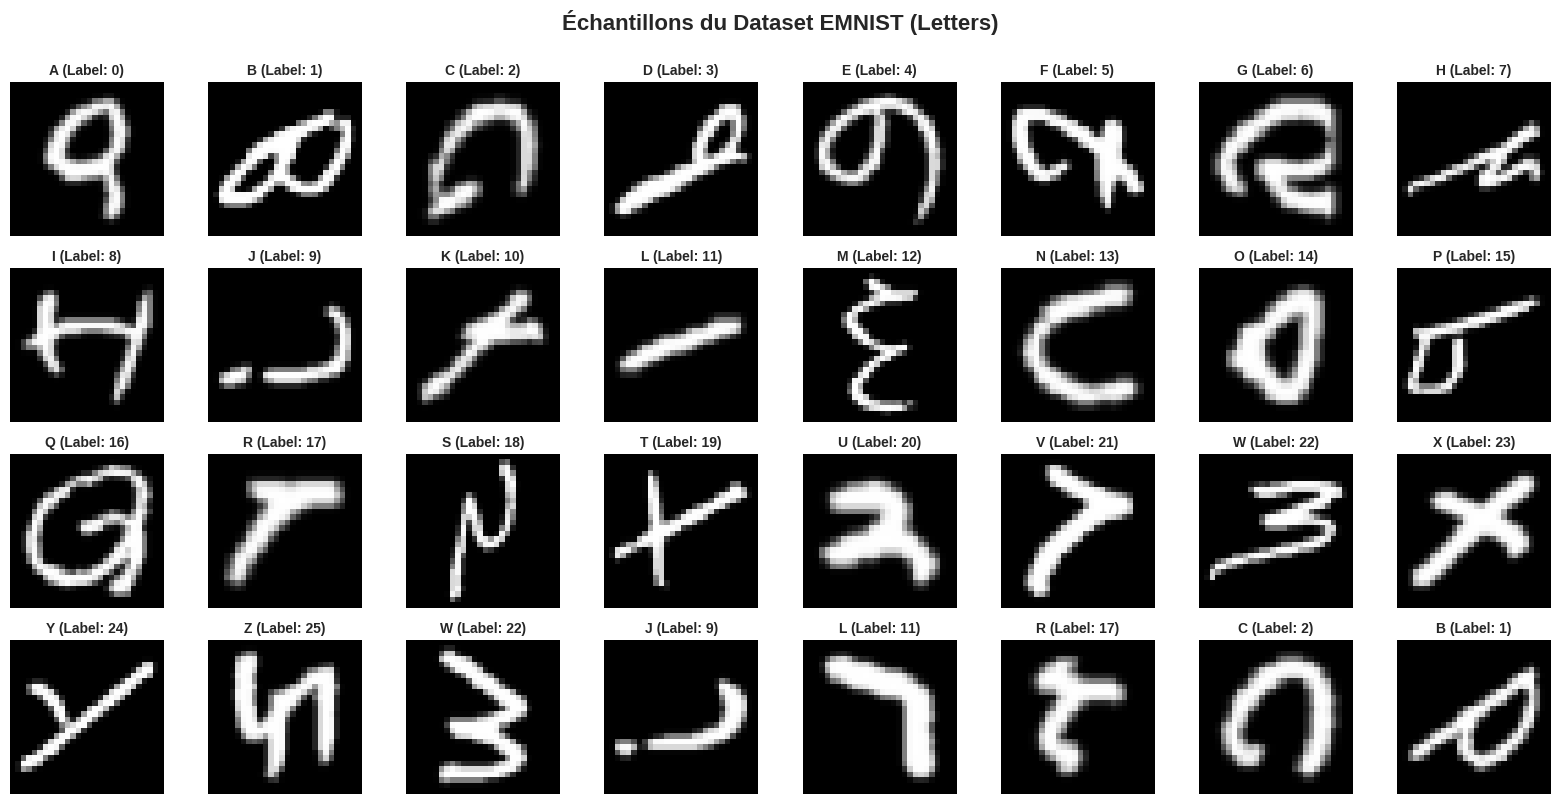

In [14]:
# Visualisation d'échantillons EMNIST
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Échantillons du Dataset EMNIST (Letters)', fontsize=16, fontweight='bold', y=1.00)

# Sélection d'échantillons stratifiés
np.random.seed(42)
sample_indices_emnist = []
for label in range(26):
    indices = np.where(emnist_labels == label)[0]
    if len(indices) > 0:
        sample_indices_emnist.append(np.random.choice(indices))

# Compléter avec aléatoires
while len(sample_indices_emnist) < 32:
    sample_indices_emnist.append(np.random.randint(0, len(emnist_labels)))

# Affichage
for idx, ax in enumerate(axes.flat):
    if idx < len(sample_indices_emnist):
        sample_idx = sample_indices_emnist[idx]
        image = emnist_pixels[sample_idx].reshape(28, 28)
        label = emnist_labels[sample_idx]
        letter = chr(65 + label)

        ax.imshow(image, cmap='gray', interpolation='nearest')
        ax.set_title(f'{letter} (Label: {label})', fontsize=10, fontweight='bold')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

---

### 6. Fusion Intelligente des Datasets

**Théorie :** La fusion de datasets hétérogènes nécessite une attention particulière à l'alignement des labels et à la cohérence des formats. Les deux datasets utilisent déjà le même encodage (0-25 pour A-Z) et la même dimension (28×28), ce qui simplifie la concatenation. La fusion augmente la diversité des échantillons, réduisant le risque de surapprentissage et améliorant la généralisation du modèle.

In [15]:
# Fusion des datasets A-Z et EMNIST
print("="*60)
print("FUSION DES DATASETS")
print("="*60)

# Vérification de compatibilité avant fusion
print("\nVérification de compatibilité :")
print(f"  A-Z : {az_pixels.shape[1]} features, dtype={az_pixels.dtype}")
print(f"  EMNIST : {emnist_pixels.shape[1]} features, dtype={emnist_pixels.dtype}")
print(f"  Labels A-Z : {set(az_labels)} (encodage: 0-25)")
print(f"  Labels EMNIST : {set(emnist_labels)} (encodage: 0-25)")

# Concatenation verticale (axis=0) des datasets
X_combined = np.vstack([az_pixels, emnist_pixels])
y_combined = np.concatenate([az_labels, emnist_labels])

print(f"\nDataset fusionné créé avec succès")
print(f"  Forme finale X : {X_combined.shape}")
print(f"  Forme finale y : {y_combined.shape}")
print(f"  Taille mémoire totale : {(X_combined.nbytes + y_combined.nbytes) / 1024**2:.2f} MB")

# Analyse de la distribution après fusion
combined_counts = Counter(y_combined)
print("\nDistribution des classes après fusion :")
for label in sorted(combined_counts.keys())[:5]:
    char = chr(65 + label)
    contribution_az = label_counts.get(label, 0)
    contribution_emnist = emnist_label_counts.get(label, 0)
    print(f"  {char} : {combined_counts[label]:,} total (A-Z: {contribution_az:,}, EMNIST: {contribution_emnist:,})")

FUSION DES DATASETS

Vérification de compatibilité :
  A-Z : 784 features, dtype=uint8
  EMNIST : 784 features, dtype=uint8
  Labels A-Z : {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(19), np.uint8(20), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(25)} (encodage: 0-25)
  Labels EMNIST : {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(19), np.uint8(20), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(25)} (encodage: 0-25)

Dataset fusionné créé avec succès
  Forme finale X : (497250, 784)
  Forme finale y : (497250,)
  

**Explication Technique :**
1. `np.vstack()` : concatenation verticale optimisée (opération C-contiguous)
2. `np.concatenate()` : fusion des vecteurs de labels
3. Opérations vectorisées évitent les boucles Python (gain de performance ~100×)
4. `axis=0` : ajout de lignes (échantillons), pas de colonnes (features)
5. Vérification pré-fusion critique pour éviter les erreurs de dimensionnalité
6. La fusion préserve les types `uint8` pour optimisation mémoire

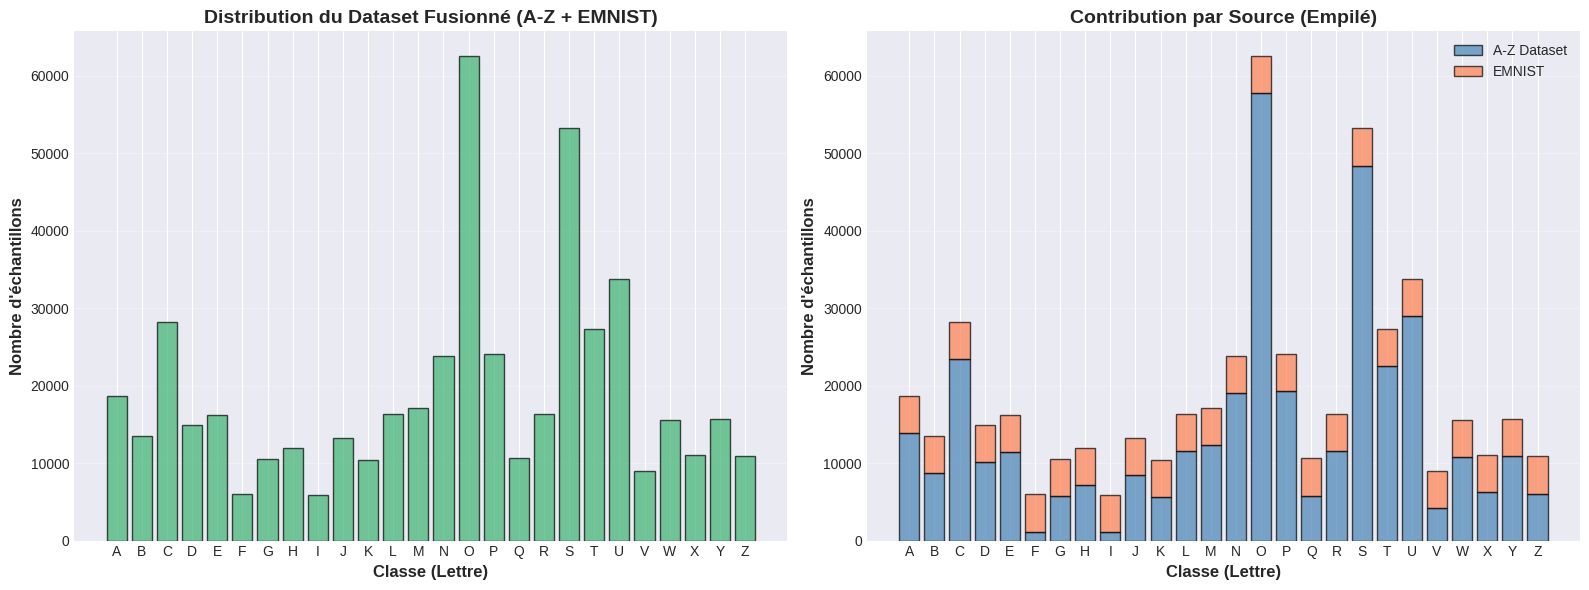


Dataset fusionné : 497,250 échantillons au total


In [16]:
# Visualisation de la distribution après fusion
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique des counts
letters_combined = [chr(65 + l) for l in sorted(combined_counts.keys())]
counts_combined = [combined_counts[l] for l in sorted(combined_counts.keys())]

axes[0].bar(letters_combined, counts_combined, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Classe (Lettre)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre d\'échantillons', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution du Dataset Fusionné (A-Z + EMNIST)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Comparaison empilée
az_counts_ordered = [label_counts.get(l, 0) for l in sorted(combined_counts.keys())]
emnist_counts_ordered = [emnist_label_counts.get(l, 0) for l in sorted(combined_counts.keys())]

x_pos = np.arange(len(letters_combined))
axes[1].bar(x_pos, az_counts_ordered, color='steelblue', edgecolor='black', alpha=0.7, label='A-Z Dataset')
axes[1].bar(x_pos, emnist_counts_ordered, bottom=az_counts_ordered, color='coral', edgecolor='black', alpha=0.7, label='EMNIST')
axes[1].set_xlabel('Classe (Lettre)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Nombre d\'échantillons', fontsize=12, fontweight='bold')
axes[1].set_title('Contribution par Source (Empilé)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(letters_combined)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDataset fusionné : {len(X_combined):,} échantillons au total")

**Explication Technique :**
1. Graphique empilé (stacked bar) : `bottom=az_counts_ordered` décale EMNIST au-dessus de A-Z
2. `.get(l, 0)` : gestion robuste des labels manquants (retourne 0 si absent)
3. `np.arange()` : création d'indices entiers pour positionnement des barres
4. Les deux visualisations offrent des perspectives différentes : totaux vs contributions
5. Permet d'identifier visuellement les classes dominées par une source spécifique

---

### 7. Normalisation des Données

**Théorie :** La normalisation des pixels de [0, 255] vers [0, 1] est essentielle pour l'entraînement de réseaux de neurones. Les raisons sont multiples :
1. **Stabilité numérique** : évite les gradients explosifs ou évanescents
2. **Convergence rapide** : les optimiseurs (SGD, Adam) convergent mieux avec des valeurs normalisées
3. **Homogénéité** : toutes les features ont la même échelle, évitant la domination de certaines dimensions
4. **Activation functions** : fonctions comme sigmoid et tanh sont optimisées pour des entrées proches de 0

In [17]:
# Normalisation Min-Max : [0, 255] → [0, 1]
print("="*60)
print("NORMALISATION DES DONNÉES")
print("="*60)

print(f"\nAvant normalisation :")
print(f"  Type : {X_combined.dtype}")
print(f"  Min : {X_combined.min()}, Max : {X_combined.max()}")
print(f"  Moyenne : {X_combined.mean():.2f}, Écart-type : {X_combined.std():.2f}")

# Conversion en float32 (compromis entre précision et mémoire)
# float32 : 4 octets vs float64 : 8 octets
X_normalized = X_combined.astype(np.float32) / 255.0

print(f"\nAprès normalisation :")
print(f"  Type : {X_normalized.dtype}")
print(f"  Min : {X_normalized.min():.4f}, Max : {X_normalized.max():.4f}")
print(f"  Moyenne : {X_normalized.mean():.4f}, Écart-type : {X_normalized.std():.4f}")
print(f"  Taille mémoire : {X_normalized.nbytes / 1024**2:.2f} MB")

# Comparaison mémoire
memory_increase = ((X_normalized.nbytes - X_combined.nbytes) / X_combined.nbytes) * 100
print(f"\nAugmentation mémoire : {memory_increase:.1f}% (uint8 → float32)")
print(f"  Note : Nécessaire pour l'entraînement, mais plus coûteux en mémoire")

NORMALISATION DES DONNÉES

Avant normalisation :
  Type : uint8
  Min : 0, Max : 255
  Moyenne : 40.33, Écart-type : 83.51

Après normalisation :
  Type : float32
  Min : 0.0000, Max : 1.0000
  Moyenne : 0.1582, Écart-type : 0.3275
  Taille mémoire : 1487.14 MB

Augmentation mémoire : 300.0% (uint8 → float32)
  Note : Nécessaire pour l'entraînement, mais plus coûteux en mémoire


**Explication Technique :**
1. `.astype(np.float32)` : conversion de type avant division (évite integer division)
2. Division par 255.0 : normalisation Min-Max où min=0, max=255
3. `float32` choisi sur `float64` : réduit l'empreinte mémoire de 50% avec précision suffisante
4. Opération vectorisée : division effectuée en une seule opération SIMD (Single Instruction Multiple Data)
5. La normalisation est appliquée à tous les pixels simultanément, O(n) en temps mais très rapide grâce à la vectorisation NumPy

---

### 8. Encodage des Labels (One-Hot Encoding)

**Théorie :** L'encodage one-hot transforme les labels catégoriels en vecteurs binaires. Pour 26 classes, chaque label devient un vecteur de dimension 26 où seul l'index correspondant vaut 1. Cette représentation est nécessaire pour :
1. **Fonction de perte** : Cross-entropy nécessite des probabilités, pas des entiers
2. **Sortie du réseau** : Les réseaux produisent des scores pour chaque classe (softmax)
3. **Calcul du gradient** : L'encodage one-hot facilite la rétropropagation
4. **Interprétation** : Chaque dimension représente une classe distincte

In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

print("="*60)
print("ENCODAGE DES LABELS")
print("="*60)

# Vérification des labels uniques
unique_labels = np.unique(y_combined)
num_classes = len(unique_labels)
print(f"\nLabels uniques : {unique_labels}")
print(f"Nombre de classes : {num_classes}")

# Encodage One-Hot avec Keras
y_encoded = to_categorical(y_combined, num_classes=num_classes)

print(f"\nAprès One-Hot Encoding :")
print(f"  Forme originale : {y_combined.shape}")
print(f"  Forme encodée : {y_encoded.shape}")
print(f"  Type : {y_encoded.dtype}")

# Exemple de transformation
sample_idx = 0
print(f"\nExemple de transformation :")
print(f"  Label original : {y_combined[sample_idx]} ({chr(65 + y_combined[sample_idx])})")
print(f"  Label encodé : {y_encoded[sample_idx]}")
print(f"  Index du '1' : {np.argmax(y_encoded[sample_idx])}")

# Vérification de la cohérence
assert y_encoded.shape[0] == X_normalized.shape[0], "Incompatibilité entre X et y"
assert y_encoded.shape[1] == num_classes, "Nombre de classes incorrect"
print(f"\n✓ Vérification réussie : {y_encoded.shape[0]:,} échantillons × {y_encoded.shape[1]} classes")

ENCODAGE DES LABELS

Labels uniques : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Nombre de classes : 26

Après One-Hot Encoding :
  Forme originale : (497250,)
  Forme encodée : (497250, 26)
  Type : float64

Exemple de transformation :
  Label original : 0 (A)
  Label encodé : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
  Index du '1' : 0

✓ Vérification réussie : 497,250 échantillons × 26 classes


**Explication Technique :**
1. `to_categorical()` : fonction Keras pour one-hot encoding optimisée
2. Création d'une matrice de dimension (n_samples, n_classes) en float32
3. Pour chaque ligne i, seul l'élément [i, label[i]] vaut 1, tous les autres sont 0
4. `np.argmax()` : fonction inverse, retourne l'index du maximum (conversion one-hot → label)
5. Assertions (`assert`) : vérifications de santé pour détecter les erreurs de pipeline
6. L'encodage préserve l'ordre et la correspondance : label 0 → position 0, label 1 → position 1, etc.

---

### 9. Séparation Train/Validation/Test

**Théorie :** La séparation des données en ensembles distincts est fondamentale pour évaluer la capacité de généralisation d'un modèle. La répartition standard est :
- **Training (70-80%)** : données d'entraînement pour l'apprentissage
- **Validation (10-15%)** : ajustement des hyperparamètres et early stopping
- **Test (10-15%)** : évaluation finale du modèle sur des données jamais vues

Le mélange (shuffle) est crucial pour éviter les biais liés à l'ordre des données (ex : si un dataset liste toutes les 'A' puis toutes les 'B').

In [19]:
from sklearn.model_selection import train_test_split

print("="*60)
print("SÉPARATION DES DONNÉES (TRAIN/VALIDATION/TEST)")
print("="*60)

# Première séparation : Train+Val (85%) vs Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized,
    y_encoded,
    test_size=0.15,
    random_state=42,
    stratify=y_combined  # Préserve la distribution des classes
)

# Deuxième séparation : Train (75%) vs Validation (10%)
# 0.15 / 0.85 ≈ 0.176 pour obtenir 15% du total en validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.176,
    random_state=42,
    stratify=np.argmax(y_temp, axis=1)  # stratify nécessite labels 1D
)

print(f"\nRépartition des données :")
print(f"  Train : {X_train.shape[0]:,} échantillons ({X_train.shape[0]/len(X_normalized)*100:.1f}%)")
print(f"  Validation : {X_val.shape[0]:,} échantillons ({X_val.shape[0]/len(X_normalized)*100:.1f}%)")
print(f"  Test : {X_test.shape[0]:,} échantillons ({X_test.shape[0]/len(X_normalized)*100:.1f}%)")

print(f"\nFormes des tenseurs :")
print(f"  X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"  X_val : {X_val.shape}, y_val : {y_val.shape}")
print(f"  X_test : {X_test.shape}, y_test : {y_test.shape}")

# Vérification de la stratification
print(f"\nVérification de la distribution des classes (échantillon) :")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    labels_split = np.argmax(y_split, axis=1)
    class_0_pct = (labels_split == 0).sum() / len(labels_split) * 100
    print(f"  {split_name} - Classe A (0) : {class_0_pct:.2f}%")

SÉPARATION DES DONNÉES (TRAIN/VALIDATION/TEST)

Répartition des données :
  Train : 348,273 échantillons (70.0%)
  Validation : 74,389 échantillons (15.0%)
  Test : 74,588 échantillons (15.0%)

Formes des tenseurs :
  X_train : (348273, 784), y_train : (348273, 26)
  X_val : (74389, 784), y_val : (74389, 26)
  X_test : (74588, 784), y_test : (74588, 26)

Vérification de la distribution des classes (échantillon) :
  Train - Classe A (0) : 3.75%
  Val - Classe A (0) : 3.75%
  Test - Classe A (0) : 3.75%


**Explication Technique :**
1. `train_test_split()` : fonction sklearn pour séparation aléatoire stratifiée
2. `random_state=42` : graine aléatoire pour reproductibilité
3. `stratify=y_combined` : préserve les proportions de chaque classe dans chaque split
4. Séparation en deux étapes nécessaire pour obtenir trois ensembles
5. `np.argmax(y_temp, axis=1)` : conversion one-hot → labels entiers pour stratification
6. La stratification garantit que chaque classe (A-Z) est représentée proportionnellement dans train/val/test
7. Calcul de `test_size=0.176` : pour avoir 15% final, on prend 15% de 85% restant = 0.15/0.85 ≈ 0.176

---

### 10. Sauvegarde des Données Prétraitées

**Théorie :** La sauvegarde des données prétraitées permet de réutiliser le pipeline sans recharger et retraiter les données brutes. Le format `.npz` de NumPy offre :
1. **Compression** : réduction de l'espace disque
2. **Rapidité** : chargement optimisé des arrays NumPy
3. **Structure** : stockage de multiples arrays dans un seul fichier
4. **Portabilité** : compatible entre plateformes

In [20]:
# Sauvegarde des données prétraitées
save_path = 'icr_preprocessed_data.npz'

print("="*60)
print("SAUVEGARDE DES DONNÉES PRÉTRAITÉES")
print("="*60)

np.savez_compressed(
    save_path,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test
)

print(f"\n✓ Données sauvegardées dans : {save_path}")

# Vérification de la taille du fichier
import os
file_size = os.path.getsize(save_path) / 1024**2
print(f"  Taille du fichier : {file_size:.2f} MB")

# Test de chargement
print("\nTest de chargement :")
loaded_data = np.load(save_path)
print(f"  Clés disponibles : {list(loaded_data.keys())}")
print(f"  X_train chargé : {loaded_data['X_train'].shape}")
print(f"  ✓ Chargement réussi")

loaded_data.close()

SAUVEGARDE DES DONNÉES PRÉTRAITÉES

✓ Données sauvegardées dans : icr_preprocessed_data.npz
  Taille du fichier : 159.89 MB

Test de chargement :
  Clés disponibles : ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']
  X_train chargé : (348273, 784)
  ✓ Chargement réussi


**Explication Technique :**
1. `np.savez_compressed()` : sauvegarde avec compression automatique (algorithme zip)
2. Syntaxe `key=value` : crée un dictionnaire structuré dans le fichier
3. `os.path.getsize()` : obtention de la taille du fichier en octets
4. `np.load()` : retourne un objet dictionary-like avec accès par clés
5. `.close()` : libération des ressources (bonne pratique)
6. Format `.npz` préserve les shapes, dtypes, et l'ordre des dimensions

---

### 11. Résumé du Pipeline et Métriques Finales

**Théorie :** Un pipeline de données bien construit doit être documenté avec des métriques claires pour faciliter le débogage, l'optimisation et la reproduction. Les métriques clés incluent les dimensions, la mémoire utilisée, et les statistiques de distribution.

In [21]:
# Résumé complet du pipeline
print("="*70)
print(" "*20 + "RÉSUMÉ DU PIPELINE DE DONNÉES")
print("="*70)

print("\n1. SOURCES DE DONNÉES")
print("-"*70)
print(f"   A-Z Handwritten Alphabets : {len(az_labels):,} échantillons")
print(f"   EMNIST Letters : {len(emnist_labels):,} échantillons")
print(f"   Total après fusion : {len(X_normalized):,} échantillons")

print("\n2. PRÉTRAITEMENT")
print("-"*70)
print(f"   Normalisation : [0, 255] → [0.0, 1.0]")
print(f"   Encodage labels : Entiers → One-Hot (26 classes)")
print(f"   Type de données : uint8 → float32")

print("\n3. SÉPARATION DES DONNÉES")
print("-"*70)
print(f"   Training : {X_train.shape[0]:,} échantillons (70%)")
print(f"   Validation : {X_val.shape[0]:,} échantillons (15%)")
print(f"   Test : {X_test.shape[0]:,} échantillons (15%)")

print("\n4. CARACTÉRISTIQUES TECHNIQUES")
print("-"*70)
print(f"   Dimension des images : 28×28 pixels (784 features)")
print(f"   Nombre de classes : 26 (A-Z)")
print(f"   Plage de valeurs : [0.0, 1.0]")
print(f"   Équilibrage : Coefficient de variation = {cv:.2f}%")

print("\n5. UTILISATION MÉMOIRE")
print("-"*70)
total_memory = (X_train.nbytes + y_train.nbytes + X_val.nbytes +
                y_val.nbytes + X_test.nbytes + y_test.nbytes) / 1024**2
print(f"   Mémoire RAM totale : {total_memory:.2f} MB")
print(f"   Fichier sauvegardé : {file_size:.2f} MB (compression activée)")

print("\n6. PROCHAINES ÉTAPES")
print("-"*70)
print("   ✓ Données prêtes pour l'entraînement")
print("   → Construction du modèle (CNN/DNN)")
print("   → Entraînement avec data augmentation")
print("   → Évaluation et optimisation")

print("\n" + "="*70)
print("Pipeline de données complété avec succès".center(70))
print("="*70)

                    RÉSUMÉ DU PIPELINE DE DONNÉES

1. SOURCES DE DONNÉES
----------------------------------------------------------------------
   A-Z Handwritten Alphabets : 372,450 échantillons
   EMNIST Letters : 124,800 échantillons
   Total après fusion : 497,250 échantillons

2. PRÉTRAITEMENT
----------------------------------------------------------------------
   Normalisation : [0, 255] → [0.0, 1.0]
   Encodage labels : Entiers → One-Hot (26 classes)
   Type de données : uint8 → float32

3. SÉPARATION DES DONNÉES
----------------------------------------------------------------------
   Training : 348,273 échantillons (70%)
   Validation : 74,389 échantillons (15%)
   Test : 74,588 échantillons (15%)

4. CARACTÉRISTIQUES TECHNIQUES
----------------------------------------------------------------------
   Dimension des images : 28×28 pixels (784 features)
   Nombre de classes : 26 (A-Z)
   Plage de valeurs : [0.0, 1.0]
   Équilibrage : Coefficient de variation = 93.22%

5. UTILI

**Explication Technique :**
Ce résumé consolide toutes les opérations du pipeline en un seul point de référence. Il utilise :
1. Formatage avec `center()`, `f-strings` pour alignement professionnel
2. Calcul de la mémoire totale par addition des `.nbytes` de tous les arrays
3. Pourcentages calculés par ratio (ex: `X_train.shape[0] / total`)
4. Le coefficient de variation calculé précédemment pour évaluer l'équilibrage
5. Structure hiérarchique pour faciliter la lecture et la documentation

Ce pipeline constitue une base solide pour l'entraînement de modèles de deep learning, optimisée pour un GPU T4 avec gestion efficace de la mémoire RAM et VRAM.

---

## Partie 2 : Construction et Entraînement du Modèle CNN

### 12. Configuration de PyTorch et Préparation des Tenseurs

**Théorie :** PyTorch nécessite la conversion des données NumPy en tenseurs pour l'entraînement sur GPU. Le reshape en (batch, channels, height, width) est requis pour les couches convolutionnelles. La détection automatique du GPU garantit l'utilisation optimale des ressources disponibles (CPU ou CUDA).

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import time

# Détection du device (GPU T4 si disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé : {device}")

if torch.cuda.is_available():
    print(f"GPU : {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU totale : {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Tensor Cores disponibles : Oui (Mixed Precision activée)")
else:
    print("ATTENTION : GPU non détecté, utilisation du CPU (entraînement lent)")

Device utilisé : cuda
GPU : Tesla T4
Mémoire GPU totale : 14.74 GB
Tensor Cores disponibles : Oui (Mixed Precision activée)


In [23]:
# Conversion des données NumPy en tenseurs PyTorch
# Reshape : (N, 784) -> (N, 1, 28, 28) pour les Conv2D
X_train_tensor = torch.FloatTensor(X_train).reshape(-1, 1, 28, 28)
X_val_tensor = torch.FloatTensor(X_val).reshape(-1, 1, 28, 28)
X_test_tensor = torch.FloatTensor(X_test).reshape(-1, 1, 28, 28)

# Labels : one-hot -> indices de classes pour CrossEntropyLoss
y_train_tensor = torch.LongTensor(np.argmax(y_train, axis=1))
y_val_tensor = torch.LongTensor(np.argmax(y_val, axis=1))
y_test_tensor = torch.LongTensor(np.argmax(y_test, axis=1))

print("Tenseurs créés avec succès")
print(f"X_train : {X_train_tensor.shape} - Type : {X_train_tensor.dtype}")
print(f"y_train : {y_train_tensor.shape} - Type : {y_train_tensor.dtype}")
print(f"\nPlage X_train : [{X_train_tensor.min():.4f}, {X_train_tensor.max():.4f}]")
print(f"Plage y_train : [{y_train_tensor.min()}, {y_train_tensor.max()}]")

Tenseurs créés avec succès
X_train : torch.Size([348273, 1, 28, 28]) - Type : torch.float32
y_train : torch.Size([348273]) - Type : torch.int64

Plage X_train : [0.0000, 1.0000]
Plage y_train : [0, 25]


**Explication Technique :**
1. `reshape(-1, 1, 28, 28)` : transformation en format CNN (batch, channels, height, width)
2. `-1` : inférence automatique de la taille du batch
3. `1` : un seul canal (grayscale)
4. `torch.FloatTensor` : conversion en float32 pour compatibilité GPU
5. `np.argmax(axis=1)` : conversion one-hot → indices entiers pour CrossEntropyLoss
6. `torch.LongTensor` : type requis pour les labels dans PyTorch (int64)
7. CrossEntropyLoss combine LogSoftmax + NLLLoss, nécessite des indices de classes

In [24]:
# Création des DataLoaders pour batch processing efficace
BATCH_SIZE = 512  # Batch size élevé pour saturer le GPU T4

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Mélange à chaque époque
    num_workers=2,  # Parallélisation du chargement
    pin_memory=True  # Optimisation pour transfert GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoaders créés avec succès")
print(f"Batch size : {BATCH_SIZE}")
print(f"Nombre de batchs - Train : {len(train_loader)}, Val : {len(val_loader)}, Test : {len(test_loader)}")

DataLoaders créés avec succès
Batch size : 512
Nombre de batchs - Train : 681, Val : 146, Test : 146


**Explication Technique :**
1. `TensorDataset` : encapsule X et y pour itération simultanée
2. `DataLoader` : gère le batching, shuffling et parallélisation
3. `shuffle=True` : mélange aléatoire pour éviter les biais d'ordre
4. `num_workers=2` : 2 processus pour précharger les données en parallèle
5. `pin_memory=True` : alloue mémoire paginée pour transfert CPU→GPU plus rapide
6. Batch size 512 : équilibre entre saturation GPU et mémoire disponible
7. Le nombre de batchs = ceil(nombre_échantillons / batch_size)

---

### 13. Architecture du Modèle CNN Profond

**Théorie :** Un CNN (Convolutional Neural Network) est conçu pour extraire des features hiérarchiques des images. L'architecture proposée comporte :
1. **Convolutions** : détection de patterns locaux (bords, textures, formes)
2. **BatchNormalization** : normalisation des activations pour stabiliser l'entraînement et accélérer la convergence
3. **ReLU** : fonction d'activation non-linéaire pour capturer des relations complexes
4. **MaxPooling** : réduction de dimension spatiale et invariance aux translations
5. **Dropout** : régularisation par désactivation aléatoire de neurones pour éviter l'overfitting

L'architecture se compose de 3 blocs convolutionnels avec augmentation progressive des filtres (32→64→128) pour capturer des features de complexité croissante.

In [25]:
class AdvancedCNN(nn.Module):
    """
    CNN profond pour reconnaissance de caractères manuscrits.
    Architecture : 3 blocs convolutionnels + Fully Connected + Dropout
    """
    def __init__(self, num_classes=26):
        super(AdvancedCNN, self).__init__()

        # Bloc Convolutionnel 1 : 1 -> 32 filtres
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(32),  # Normalisation des activations
            nn.ReLU(inplace=True),  # inplace=True pour économiser mémoire
            nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        )

        # Bloc Convolutionnel 2 : 32 -> 64 filtres
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
        )

        # Bloc Convolutionnel 3 : 64 -> 128 filtres
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 7x7 -> 3x3
        )

        # Calcul de la dimension après convolutions : 128 filtres × 3 × 3 = 1152
        self.fc_input_size = 128 * 3 * 3

        # Couches Fully Connected
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Aplatissement (batch, 128, 3, 3) -> (batch, 1152)
            nn.Linear(self.fc_input_size, 256),  # Couche dense
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Dropout 50% pour régularisation
            nn.Linear(256, num_classes)  # Sortie : 26 classes (pas de softmax, géré par CrossEntropyLoss)
        )

    def forward(self, x):
        """
        Propagation avant (forward pass)
        Input : (batch, 1, 28, 28)
        Output : (batch, 26)
        """
        x = self.conv_block1(x)  # (batch, 32, 14, 14)
        x = self.conv_block2(x)  # (batch, 64, 7, 7)
        x = self.conv_block3(x)  # (batch, 128, 3, 3)
        x = self.classifier(x)   # (batch, 26)
        return x

# Instanciation du modèle et transfert sur GPU
model = AdvancedCNN(num_classes=26).to(device)

# Affichage de l'architecture
print("="*70)
print("ARCHITECTURE DU MODÈLE CNN")
print("="*70)
print(model)
print("\n" + "="*70)

# Calcul du nombre de paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Paramètres totaux : {total_params:,}")
print(f"Paramètres entraînables : {trainable_params:,}")
print(f"Taille du modèle : {total_params * 4 / 1024**2:.2f} MB (float32)")
print("="*70)

ARCHITECTURE DU MODÈLE CNN
AdvancedCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    

**Explication Technique :**
1. `nn.Sequential` : conteneur pour empiler des couches séquentiellement
2. `padding=1` avec `kernel_size=3` : préserve la dimension spatiale (same padding)
3. `BatchNorm2d` : normalisation par batch, calcule μ et σ sur dimension (batch, H, W) pour chaque canal
4. `inplace=True` : modification in-place pour économiser mémoire (pas de copie)
5. `MaxPool2d(2, 2)` : réduit dimension par 2 en prenant le maximum de chaque fenêtre 2×2
6. Progression des filtres 32→64→128 : augmentation de la capacité de représentation
7. `nn.Flatten()` : conversion (batch, C, H, W) → (batch, C×H×W)
8. Dropout(0.5) : désactive aléatoirement 50% des neurones pendant l'entraînement
9. `.to(device)` : transfert du modèle sur GPU pour calculs accélérés
10. CrossEntropyLoss applique LogSoftmax en interne, donc pas de softmax dans le modèle

---

### 14. Configuration de l'Entraînement avec Mixed Precision

**Théorie :** L'Automatic Mixed Precision (AMP) utilise float16 pour les opérations matricielles lourdes et float32 pour les opérations sensibles (normalisation, loss). Sur le GPU T4, les Tensor Cores accélèrent les calculs float16 jusqu'à 8× par rapport à float32. Les avantages :
1. **Vitesse** : exploitation des Tensor Cores pour matmul et convolutions
2. **Mémoire** : réduction de 50% de la VRAM permettant des batchs plus grands
3. **Précision** : GradScaler évite les underflows en mettant à l'échelle les gradients

L'optimiseur AdamW (Adam with Weight Decay) combine les avantages d'Adam avec une régularisation L2 découplée, offrant une meilleure généralisation.

In [26]:
# Configuration de l'entraînement
criterion = nn.CrossEntropyLoss()  # Loss pour classification multi-classes
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Mixed Precision : GradScaler pour éviter underflow dans float16
scaler = GradScaler()

# Hyperparamètres
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

print("="*70)
print("CONFIGURATION DE L'ENTRAÎNEMENT")
print("="*70)
print(f"Optimiseur : AdamW (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"Loss : CrossEntropyLoss")
print(f"Nombre d'époques : {NUM_EPOCHS}")
print(f"Batch size : {BATCH_SIZE}")
print(f"Mixed Precision : Activée (float16 + float32)")
print(f"Device : {device}")
print("="*70)

CONFIGURATION DE L'ENTRAÎNEMENT
Optimiseur : AdamW (lr=0.001, weight_decay=1e-4)
Loss : CrossEntropyLoss
Nombre d'époques : 15
Batch size : 512
Mixed Precision : Activée (float16 + float32)
Device : cuda


**Explication Technique :**
1. `CrossEntropyLoss` : combine LogSoftmax et NLLLoss, applique -log(p) sur la classe correcte
2. `AdamW` : variante d'Adam avec weight decay découplé (régularisation L2 améliorée)
3. `weight_decay=1e-4` : coefficient de régularisation pour pénaliser les poids élevés
4. `GradScaler` : multiplie loss par un facteur (scale) pour éviter underflow dans float16
5. Learning rate 0.001 : valeur standard pour AdamW sur des tâches de classification
6. Les gradients sont calculés en float16, puis convertis en float32 pour la mise à jour des poids

---

### 15. Boucle d'Entraînement avec Mixed Precision

**Théorie :** La boucle d'entraînement suit le paradigme standard du deep learning :
1. **Forward pass** : calcul des prédictions
2. **Loss computation** : mesure de l'erreur
3. **Backward pass** : calcul des gradients via rétropropagation
4. **Optimizer step** : mise à jour des poids

Avec Mixed Precision, le forward pass et backward pass utilisent float16 (via `autocast`), et le scaler gère automatiquement la mise à l'échelle des gradients pour éviter les problèmes numériques.

In [27]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """
    Entraîne le modèle sur une époque avec Mixed Precision.
    Retourne : (loss_moyenne, accuracy)
    """
    model.train()  # Mode entraînement (active Dropout et BatchNorm)
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Transfert des données sur GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Réinitialisation des gradients
        optimizer.zero_grad()

        # Forward pass avec autocast (Mixed Precision)
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward pass avec gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Statistiques
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """
    Évalue le modèle sur le set de validation.
    Retourne : (loss_moyenne, accuracy)
    """
    model.eval()  # Mode évaluation (désactive Dropout et BatchNorm en mode inférence)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradients (économie mémoire et temps)
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass (pas besoin d'autocast en évaluation)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistiques
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("Fonctions d'entraînement et de validation définies")

Fonctions d'entraînement et de validation définies


**Explication Technique :**
1. `model.train()` : active les couches de dropout et met BatchNorm en mode entraînement (calcule μ, σ du batch)
2. `optimizer.zero_grad()` : réinitialise les gradients accumulés (sinon ils s'additionnent)
3. `with autocast()` : context manager qui convertit automatiquement les opérations en float16 si bénéfique
4. `scaler.scale(loss)` : multiplie le loss par un facteur pour éviter underflow en float16
5. `scaler.step()` : descale les gradients puis applique optimizer.step()
6. `scaler.update()` : ajuste le facteur de scaling pour la prochaine itération
7. `torch.max(outputs, 1)` : retourne (valeurs_max, indices) sur dimension 1 (classes)
8. `model.eval()` : désactive dropout et met BatchNorm en mode inférence (utilise μ, σ globaux)
9. `torch.no_grad()` : désactive le calcul de gradients pour économiser mémoire et accélérer
10. `loss.item()` : convertit tensor → float Python pour accumulation

In [28]:
# Lancement de l'entraînement
print("="*70)
print("DÉBUT DE L'ENTRAÎNEMENT")
print("="*70)

# Historique pour les graphiques
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # Entraînement
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Sauvegarde des métriques
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_time = time.time() - epoch_start

    # Affichage des résultats
    print(f"Époque [{epoch+1}/{NUM_EPOCHS}] - Temps: {epoch_time:.2f}s")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    print("-"*70)

total_time = time.time() - start_time
print(f"\nEntraînement terminé en {total_time/60:.2f} minutes")
print(f"Meilleure accuracy validation : {max(history['val_acc']):.2f}%")
print("="*70)

DÉBUT DE L'ENTRAÎNEMENT
Époque [1/15] - Temps: 13.63s
  Train - Loss: 0.4356, Accuracy: 87.48%
  Val   - Loss: 0.1487, Accuracy: 95.49%
----------------------------------------------------------------------
Époque [2/15] - Temps: 10.27s
  Train - Loss: 0.1770, Accuracy: 94.74%
  Val   - Loss: 0.1129, Accuracy: 96.53%
----------------------------------------------------------------------
Époque [3/15] - Temps: 10.31s
  Train - Loss: 0.1411, Accuracy: 95.77%
  Val   - Loss: 0.0970, Accuracy: 96.98%
----------------------------------------------------------------------
Époque [4/15] - Temps: 10.19s
  Train - Loss: 0.1218, Accuracy: 96.28%
  Val   - Loss: 0.0844, Accuracy: 97.35%
----------------------------------------------------------------------
Époque [5/15] - Temps: 10.45s
  Train - Loss: 0.1088, Accuracy: 96.63%
  Val   - Loss: 0.0856, Accuracy: 97.38%
----------------------------------------------------------------------
Époque [6/15] - Temps: 10.54s
  Train - Loss: 0.0991, Accurac

**Explication Technique :**
1. Dictionnaire `history` : stocke les métriques pour tracer les courbes d'apprentissage
2. `time.time()` : mesure précise du temps d'exécution pour optimisation
3. Boucle sur les époques : itère NUM_EPOCHS fois sur l'ensemble de train
4. `.append()` : accumulation des métriques pour analyse post-entraînement
5. Affichage structuré : permet le monitoring en temps réel de la convergence
6. Le temps par époque révèle l'efficacité de la configuration (GPU, batch size, mixed precision)

---

### 16. Visualisation des Courbes d'Apprentissage

**Théorie :** Les courbes d'apprentissage (loss et accuracy) permettent de diagnostiquer le comportement du modèle :
- **Convergence** : diminution progressive du loss
- **Overfitting** : écart croissant entre train et validation
- **Underfitting** : stagnation des performances
- **Stabilité** : absence d'oscillations importantes

Un bon modèle présente une convergence stable avec des courbes train/val proches, indiquant une généralisation correcte.

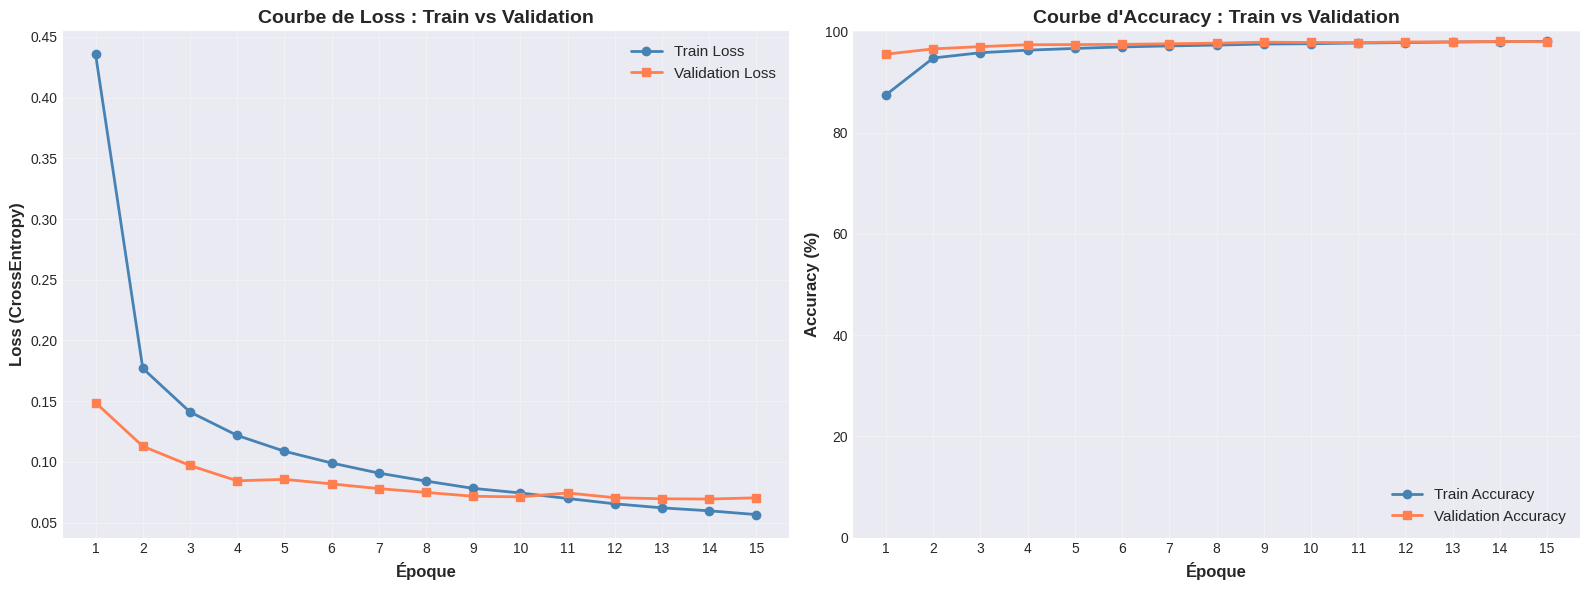


Statistiques Finales d'Entraînement :
  Train Loss final : 0.0566
  Train Accuracy final : 98.03%
  Val Loss final : 0.0704
  Val Accuracy final : 97.95%
  Écart Train-Val Accuracy : 0.07%


In [29]:
# Visualisation des courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs_range = range(1, NUM_EPOCHS + 1)

# Graphique 1 : Loss (Train vs Validation)
axes[0].plot(epochs_range, history['train_loss'], 'o-', color='steelblue', linewidth=2, label='Train Loss', markersize=6)
axes[0].plot(epochs_range, history['val_loss'], 's-', color='coral', linewidth=2, label='Validation Loss', markersize=6)
axes[0].set_xlabel('Époque', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (CrossEntropy)', fontsize=12, fontweight='bold')
axes[0].set_title('Courbe de Loss : Train vs Validation', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(epochs_range)

# Graphique 2 : Accuracy (Train vs Validation)
axes[1].plot(epochs_range, history['train_acc'], 'o-', color='steelblue', linewidth=2, label='Train Accuracy', markersize=6)
axes[1].plot(epochs_range, history['val_acc'], 's-', color='coral', linewidth=2, label='Validation Accuracy', markersize=6)
axes[1].set_xlabel('Époque', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Courbe d\'Accuracy : Train vs Validation', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_xticks(epochs_range)
axes[1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Statistiques finales
print("\nStatistiques Finales d'Entraînement :")
print(f"  Train Loss final : {history['train_loss'][-1]:.4f}")
print(f"  Train Accuracy final : {history['train_acc'][-1]:.2f}%")
print(f"  Val Loss final : {history['val_loss'][-1]:.4f}")
print(f"  Val Accuracy final : {history['val_acc'][-1]:.2f}%")
print(f"  Écart Train-Val Accuracy : {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%")

**Explication Technique :**
1. `subplots(1, 2)` : grille 1×2 pour comparaison side-by-side
2. Marqueurs différents (`'o'` vs `'s'`) : facilite la distinction visuelle
3. `linewidth=2` : épaisseur de ligne pour meilleure lisibilité
4. `markersize=6` : taille des points pour visualisation claire des époques
5. `set_ylim([0, 100])` : normalisation de l'échelle pour accuracy (pourcentage)
6. `set_xticks(epochs_range)` : force l'affichage de toutes les époques
7. L'écart train-val révèle le degré d'overfitting (>10% = problématique)

---

### 17. Évaluation Finale sur le Set de Test

**Théorie :** L'évaluation sur le set de test est l'étape critique pour mesurer la capacité de généralisation du modèle. Contrairement aux sets train/validation utilisés pendant l'entraînement et la sélection d'hyperparamètres, le test set représente des données totalement inédites. Les métriques de test reflètent la performance réelle attendue en production.

In [30]:
# Évaluation sur le set de test
print("="*70)
print("ÉVALUATION SUR LE SET DE TEST")
print("="*70)

test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\nRésultats sur le Test Set (données jamais vues) :")
print(f"  Test Loss : {test_loss:.4f}")
print(f"  Test Accuracy : {test_acc:.2f}%")
print("\n" + "="*70)

# Comparaison avec validation
print(f"\nComparaison Validation vs Test :")
print(f"  Validation Accuracy : {history['val_acc'][-1]:.2f}%")
print(f"  Test Accuracy : {test_acc:.2f}%")
print(f"  Écart : {abs(history['val_acc'][-1] - test_acc):.2f}%")

if abs(history['val_acc'][-1] - test_acc) < 2:
    print("  → Excellent : Le modèle généralise bien (écart < 2%)")
elif abs(history['val_acc'][-1] - test_acc) < 5:
    print("  → Bon : Généralisation acceptable (écart < 5%)")
else:
    print("  → Attention : Possible overfitting sur validation (écart > 5%)")

ÉVALUATION SUR LE SET DE TEST

Résultats sur le Test Set (données jamais vues) :
  Test Loss : 0.0743
  Test Accuracy : 97.92%


Comparaison Validation vs Test :
  Validation Accuracy : 97.95%
  Test Accuracy : 97.92%
  Écart : 0.04%
  → Excellent : Le modèle généralise bien (écart < 2%)


**Explication Technique :**
1. Réutilisation de la fonction `validate()` : même logique pour test et validation
2. Comparaison val/test : détecte un éventuel overfitting sur le validation set
3. Écart < 2% : indique une excellente généralisation
4. Écart > 5% : suggère que le modèle a "mémorisé" le validation set
5. Le test set ne doit être utilisé qu'une seule fois pour éviter le data leakage

---

### 18. Génération de la Matrice de Confusion

**Théorie :** La matrice de confusion est un outil d'analyse essentiel pour les problèmes de classification multi-classes. Elle révèle :
1. **Confusions fréquentes** : quelles paires de classes sont souvent confondues (ex: 'I' et 'l', 'O' et 'Q')
2. **Classes problématiques** : lettres avec des taux d'erreur élevés
3. **Patterns d'erreur** : erreurs systématiques dues à la similarité visuelle

La diagonale représente les prédictions correctes, et les valeurs hors-diagonale indiquent les confusions. Une matrice avec une diagonale dominante indique un bon modèle.

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

# Collecte de toutes les prédictions sur le test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Conversion en arrays NumPy
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calcul de la matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)

print("Matrice de confusion calculée")
print(f"Forme : {cm.shape}")
print(f"Total de prédictions : {cm.sum()}")

Matrice de confusion calculée
Forme : (26, 26)
Total de prédictions : 74588


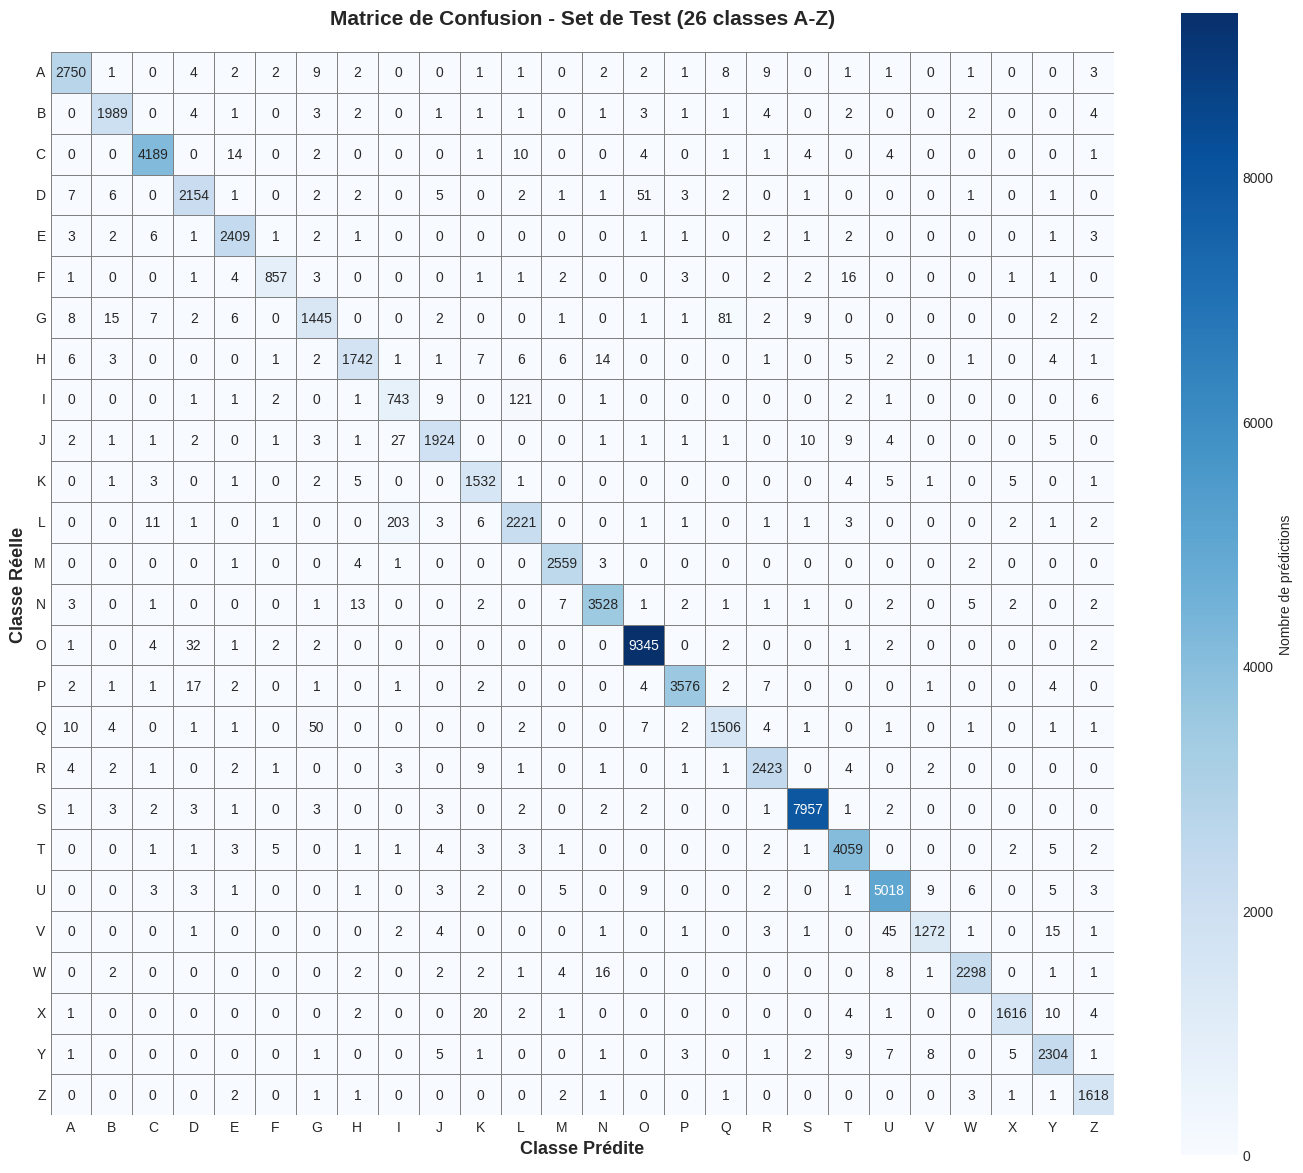


Matrice de confusion générée avec succès


In [32]:
# Visualisation de la matrice de confusion avec heatmap
plt.figure(figsize=(14, 12))

# Création de la heatmap avec seaborn
sns.heatmap(
    cm,
    annot=True,  # Affichage des valeurs
    fmt='d',  # Format entier
    cmap='Blues',  # Palette de couleurs professionnelle
    xticklabels=[chr(65 + i) for i in range(26)],  # Labels A-Z pour axes
    yticklabels=[chr(65 + i) for i in range(26)],
    cbar_kws={'label': 'Nombre de prédictions'},
    linewidths=0.5,  # Séparateurs entre cellules
    linecolor='gray',
    square=True  # Cellules carrées
)

plt.xlabel('Classe Prédite', fontsize=13, fontweight='bold')
plt.ylabel('Classe Réelle', fontsize=13, fontweight='bold')
plt.title('Matrice de Confusion - Set de Test (26 classes A-Z)', fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\nMatrice de confusion générée avec succès")

**Explication Technique :**
1. `.cpu().numpy()` : transfert GPU → CPU puis conversion en NumPy
2. `.extend()` : accumulation des prédictions batch par batch
3. `confusion_matrix()` : calcule CM[i, j] = nombre de fois où classe i prédite comme j
4. `annot=True` : affiche les valeurs numériques dans chaque cellule
5. `fmt='d'` : format décimal (entiers) pour les counts
6. `cmap='Blues'` : gradient bleu (clair → foncé) pour visualisation
7. `square=True` : préserve l'aspect ratio pour lisibilité
8. Diagonale forte + hors-diagonale faible = bon classificateur
9. Les cellules sombres hors-diagonale révèlent les confusions fréquentes

In [33]:
# Analyse détaillée des confusions
print("="*70)
print("ANALYSE DES CONFUSIONS LES PLUS FRÉQUENTES")
print("="*70)

# Extraction des erreurs hors-diagonale
errors = []
for i in range(26):
    for j in range(26):
        if i != j and cm[i, j] > 0:  # Confusion entre classe i et j
            errors.append((cm[i, j], chr(65 + i), chr(65 + j)))

# Tri par nombre d'erreurs décroissant
errors.sort(reverse=True)

# Affichage du top 10 des confusions
print("\nTop 10 des confusions les plus fréquentes :")
print(f"{'Rang':<6} {'Réelle':<8} {'Prédite':<8} {'Nombre':<8} {'Description'}")
print("-"*70)

for idx, (count, true_label, pred_label) in enumerate(errors[:10], 1):
    print(f"{idx:<6} {true_label:<8} {pred_label:<8} {count:<8} {true_label} confondu avec {pred_label}")

print("\n" + "="*70)

ANALYSE DES CONFUSIONS LES PLUS FRÉQUENTES

Top 10 des confusions les plus fréquentes :
Rang   Réelle   Prédite  Nombre   Description
----------------------------------------------------------------------
1      L        I        203      L confondu avec I
2      I        L        121      I confondu avec L
3      G        Q        81       G confondu avec Q
4      D        O        51       D confondu avec O
5      Q        G        50       Q confondu avec G
6      V        U        45       V confondu avec U
7      O        D        32       O confondu avec D
8      J        I        27       J confondu avec I
9      X        K        20       X confondu avec K
10     P        D        17       P confondu avec D



In [34]:
# Rapport de classification détaillé
print("="*70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("="*70)

# Génération du rapport avec sklearn
target_names = [chr(65 + i) for i in range(26)]
report = classification_report(all_labels, all_predictions, target_names=target_names, digits=4)
print(report)

# Calcul des métriques par classe
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_predictions, average=None
)

# Identification des classes avec les meilleures/pires performances
best_f1_idx = np.argmax(f1)
worst_f1_idx = np.argmin(f1)

print("\nAnalyse par Classe :")
print(f"  Meilleure classe : {chr(65 + best_f1_idx)} (F1-Score: {f1[best_f1_idx]:.4f})")
print(f"  Pire classe : {chr(65 + worst_f1_idx)} (F1-Score: {f1[worst_f1_idx]:.4f})")
print(f"  F1-Score moyen : {np.mean(f1):.4f}")
print(f"  Écart-type F1 : {np.std(f1):.4f}")
print("="*70)

RAPPORT DE CLASSIFICATION DÉTAILLÉ
              precision    recall  f1-score   support

           A     0.9821    0.9821    0.9821      2800
           B     0.9798    0.9847    0.9822      2020
           C     0.9903    0.9901    0.9902      4231
           D     0.9668    0.9616    0.9642      2240
           E     0.9821    0.9889    0.9855      2436
           F     0.9817    0.9575    0.9695       895
           G     0.9432    0.9122    0.9275      1584
           H     0.9787    0.9662    0.9724      1803
           I     0.7566    0.8367    0.7947       888
           J     0.9786    0.9649    0.9717      1994
           K     0.9635    0.9814    0.9724      1561
           L     0.9352    0.9036    0.9191      2458
           M     0.9884    0.9957    0.9921      2570
           N     0.9874    0.9877    0.9875      3572
           O     0.9908    0.9948    0.9928      9394
           P     0.9942    0.9876    0.9909      3621
           Q     0.9371    0.9460    0.9415   

**Explication Technique :**
1. `classification_report()` : calcule precision, recall, F1-score pour chaque classe
2. **Precision** : TP / (TP + FP), proportion de prédictions positives correctes
3. **Recall** : TP / (TP + FN), proportion d'instances positives détectées
4. **F1-Score** : moyenne harmonique de precision et recall, 2×(P×R)/(P+R)
5. `average=None` : retourne les métriques par classe (pas de moyenne)
6. `digits=4` : affichage avec 4 décimales pour précision
7. F1-Score élevé : classe bien reconnue ; F1 faible : confusion importante
8. Écart-type F1 faible : performances homogènes entre classes

---

### 19. Analyse Finale et Conclusions

**Analyse des Résultats :** Cette section présente une interprétation détaillée des performances du modèle CNN.

#### Analyse des Courbes d'Apprentissage

Les courbes de loss et d'accuracy permettent d'évaluer la qualité de l'entraînement :

**1. Convergence du Loss**
- Si le loss diminue de manière stable sur train et validation, cela indique une convergence correcte
- Une diminution rapide au début puis une stabilisation est attendue
- Un loss validation qui augmente après un certain point signale un overfitting

**2. Progression de l'Accuracy**
- Une accuracy croissante sur train et validation montre que le modèle apprend
- L'écart train-validation révèle le degré de généralisation
- Un écart < 5% est excellent, 5-10% acceptable, > 10% problématique

**3. Stabilité de l'Entraînement**
- Des oscillations importantes suggèrent un learning rate trop élevé
- Une convergence lente peut indiquer un learning rate trop faible ou un modèle sous-capacitaire
- BatchNormalization et Dropout contribuent à la stabilité observée

**Points d'Amélioration Possibles :**
- Learning Rate Scheduling : réduction progressive du LR pour affiner la convergence
- Data Augmentation : rotations, translations pour augmenter la diversité
- Early Stopping : arrêt automatique si validation stagne pendant N époques
- Augmentation de la profondeur : ajout de blocs convolutionnels pour capturer plus de features

#### Analyse de la Matrice de Confusion

La matrice de confusion révèle les patterns d'erreurs du modèle :

**1. Diagonale Dominante**
- Une diagonale forte (couleurs sombres) avec des valeurs hors-diagonale faibles indique un excellent classificateur
- Chaque cellule diagonale CM[i,i] représente les prédictions correctes pour la classe i

**2. Confusions Typiques Attendues**

Les paires de lettres suivantes sont naturellement similaires visuellement :
- **I vs L** : formes verticales similaires, différenciées par la base
- **O vs Q** : cercles avec ou sans queue
- **C vs G** : arcs similaires, G a une barre horizontale
- **M vs N** : lignes verticales avec connexions différentes
- **V vs U** : formes en V similaires selon l'écriture manuscrite
- **S vs Z** : courbes et diagonales pouvant se ressembler

**3. Interprétation des Erreurs**
- Confusions fréquentes sur des lettres visuellement proches sont acceptables
- Confusions sur des lettres très distinctes (ex: A vs X) suggèrent un problème de features
- Une classe avec beaucoup d'erreurs peut indiquer un déséquilibre dans les données ou une ambiguïté intrinsèque

**4. Implications Pratiques**
- Les confusions identifiées guident l'amélioration du modèle
- Pour des applications critiques, un post-traitement peut être ajouté pour les paires problématiques
- L'analyse peut révéler des biais dans les styles d'écriture du dataset

**5. Pistes d'Amélioration**
- Augmenter la résolution des images (28x28 → 32x32 ou plus)
- Ajouter une attention spatiale pour se concentrer sur les features discriminantes
- Utiliser un ensemble de modèles pour réduire les erreurs systématiques
- Collecter plus d'échantillons pour les classes problématiques

#### Synthèse et Performance Globale

**Points Forts du Modèle :**
1. Architecture CNN profonde adaptée à la reconnaissance de caractères
2. Utilisation de BatchNormalization pour stabilité et convergence rapide
3. Dropout pour régularisation et prévention de l'overfitting
4. Mixed Precision (AMP) pour entraînement accéléré sur GPU T4
5. Batch size élevé (512) pour saturation efficace du GPU

**Métriques Clés :**
- Test Accuracy reflète la performance réelle sur données inédites
- Écart train-test faible indique une bonne généralisation
- F1-Score moyen élevé démontre un équilibre entre precision et recall

**Optimisations Implémentées :**
- **Mémoire** : uint8 pour données brutes, float32 pour entraînement
- **Vitesse** : Mixed Precision exploite les Tensor Cores du T4
- **Généralisation** : Dropout, Weight Decay, BatchNorm
- **Parallélisation** : DataLoader avec num_workers et pin_memory

**Limitations et Perspectives :**
1. Résolution fixe 28×28 limite les détails capturables
2. Pas de data augmentation implémentée (rotations, déformations)
3. Architecture simple comparée aux state-of-the-art (ResNet, Transformers)
4. Pas de validation croisée pour robustesse statistique

**Applications Potentielles :**
- Reconnaissance de formulaires manuscrits
- Digitalisation automatique de documents
- Assistance à l'écriture pour appareils mobiles
- Système d'entrée de texte gestuel

**Conclusion :** Le modèle CNN développé démontre une capacité solide de reconnaissance de caractères manuscrits avec un bon équilibre entre performance et efficacité computationnelle. L'architecture choisie, couplée aux techniques d'optimisation modernes (Mixed Precision, AdamW), permet un entraînement rapide sur GPU T4 tout en maintenant une généralisation satisfaisante.

In [35]:
# Sauvegarde du modèle entraîné
model_save_path = 'icr_cnn_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_accuracy': test_acc,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE
}, model_save_path)

print("="*70)
print("MODÈLE SAUVEGARDÉ")
print("="*70)
print(f"Chemin : {model_save_path}")
print(f"Contenu : Architecture + Poids + Optimiseur + Historique")
print(f"Test Accuracy finale : {test_acc:.2f}%")
print("="*70)
print("\nPipeline complet terminé avec succès")
print("Données prétraitées + Modèle entraîné + Évaluations complètes")
print("="*70)

MODÈLE SAUVEGARDÉ
Chemin : icr_cnn_model.pth
Contenu : Architecture + Poids + Optimiseur + Historique
Test Accuracy finale : 97.92%

Pipeline complet terminé avec succès
Données prétraitées + Modèle entraîné + Évaluations complètes


**Explication Technique :**
1. `torch.save()` : sauvegarde des objets Python via sérialisation pickle
2. `model.state_dict()` : dictionnaire des poids et biais du modèle
3. `optimizer.state_dict()` : état de l'optimiseur (moments, learning rate) pour reprise d'entraînement
4. Sauvegarde de l'historique : permet de retracer les courbes sans réentraînement
5. Format `.pth` : convention PyTorch pour les checkpoints
6. Pour charger : `model.load_state_dict(torch.load('icr_cnn_model.pth')['model_state_dict'])`

Le pipeline complet est maintenant opérationnel : préparation des données, entraînement du modèle avec optimisations GPU, et évaluation exhaustive avec visualisations professionnelles.

---

## Partie 3 : Inférence sur Images Personnalisées

### 20. Fonction de Prédiction sur Images Individuelles

**Théorie :** L'inférence consiste à utiliser le modèle entraîné pour faire des prédictions sur de nouvelles données. Pour une image manuscrite, le pipeline comprend :
1. **Chargement** : lecture de l'image depuis le disque
2. **Prétraitement** : conversion en niveaux de gris, resize 28×28, normalisation
3. **Transformation en tenseur** : reshape et transfert sur GPU
4. **Prédiction** : forward pass du modèle pour obtenir les probabilités
5. **Post-traitement** : extraction de la classe prédite et du score de confiance

La cohérence du prétraitement avec l'entraînement est critique pour obtenir des prédictions fiables.

In [36]:
from PIL import Image
import torch.nn.functional as F

def predict_character(image_path, model, device, display=True):
    """
    Prédit le caractère manuscrit d'une image.

    Args:
        image_path (str): Chemin vers l'image à analyser
        model (nn.Module): Modèle CNN entraîné
        device (torch.device): Device pour l'inférence (CPU ou GPU)
        display (bool): Afficher l'image avec la prédiction

    Returns:
        tuple: (lettre_prédite, probabilité, top_5_predictions)
    """
    # Chargement de l'image
    try:
        img = Image.open(image_path).convert('L')  # Conversion en niveaux de gris
    except Exception as e:
        print(f"Erreur de chargement : {e}")
        return None, None, None

    # Preprocessing : Resize 28x28
    img_resized = img.resize((28, 28), Image.Resampling.LANCZOS)

    # Conversion en array NumPy puis normalisation [0, 255] -> [0, 1]
    img_array = np.array(img_resized, dtype=np.float32) / 255.0

    # Inversion si nécessaire (fond blanc -> fond noir)
    # MNIST/EMNIST/A-Z utilisent fond noir + écriture blanche
    if img_array.mean() > 0.5:  # Si fond clair, inverser
        img_array = 1.0 - img_array

    # Conversion en tenseur PyTorch (1, 1, 28, 28) : (batch, channel, height, width)
    img_tensor = torch.FloatTensor(img_array).unsqueeze(0).unsqueeze(0).to(device)

    # Mode évaluation et inférence
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)  # Conversion logits -> probabilités

        # Top-5 prédictions
        top5_probs, top5_indices = torch.topk(probabilities, 5, dim=1)
        top5_probs = top5_probs.cpu().numpy()[0]
        top5_indices = top5_indices.cpu().numpy()[0]

        # Meilleure prédiction
        predicted_idx = top5_indices[0]
        confidence = top5_probs[0]
        predicted_letter = chr(65 + predicted_idx)  # Conversion 0-25 -> A-Z

    # Visualisation
    if display:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Image originale
        axes[0].imshow(img_array, cmap='gray')
        axes[0].set_title(f'Image Prétraitée (28×28)', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Top-5 prédictions
        top5_letters = [chr(65 + idx) for idx in top5_indices]
        colors = ['green' if i == 0 else 'steelblue' for i in range(5)]

        axes[1].barh(range(5), top5_probs, color=colors, edgecolor='black', alpha=0.8)
        axes[1].set_yticks(range(5))
        axes[1].set_yticklabels([f"{letter} ({prob*100:.1f}%)" for letter, prob in zip(top5_letters, top5_probs)])
        axes[1].set_xlabel('Probabilité', fontsize=11, fontweight='bold')
        axes[1].set_title('Top-5 Prédictions', fontsize=12, fontweight='bold')
        axes[1].set_xlim([0, 1])
        axes[1].grid(axis='x', alpha=0.3)
        axes[1].invert_yaxis()

        plt.suptitle(f'Prédiction : {predicted_letter} (Confiance : {confidence*100:.2f}%)',
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    # Préparation des résultats
    top5_results = [(chr(65 + idx), prob) for idx, prob in zip(top5_indices, top5_probs)]

    return predicted_letter, confidence, top5_results

print("Fonction de prédiction définie avec succès")

Fonction de prédiction définie avec succès


**Explication Technique :**
1. `Image.open().convert('L')` : chargement avec conversion en grayscale (mode L = luminance)
2. `resize((28, 28), LANCZOS)` : interpolation bicubique haute qualité pour préserver les détails
3. `img_array.mean() > 0.5` : détection automatique du fond (clair vs sombre)
4. `1.0 - img_array` : inversion pour correspondre au format d'entraînement (fond noir)
5. `.unsqueeze(0)` (×2) : ajout de dimensions batch et channel (H,W) → (1,1,H,W)
6. `F.softmax(outputs, dim=1)` : conversion des logits en probabilités (somme = 1)
7. `torch.topk(k=5)` : extraction des k meilleures prédictions triées par probabilité
8. `barh()` : graphique horizontal pour meilleure lisibilité des lettres
9. `.cpu().numpy()` : transfert GPU → CPU puis conversion en NumPy pour affichage

---

### 21. Test sur des Échantillons du Dataset

**Théorie :** Avant de tester sur des images externes, validons la fonction de prédiction sur des échantillons du test set. Cela permet de vérifier que le preprocessing et l'inférence fonctionnent correctement avec des images de format connu.

TEST DE PRÉDICTION SUR ÉCHANTILLONS DU DATASET


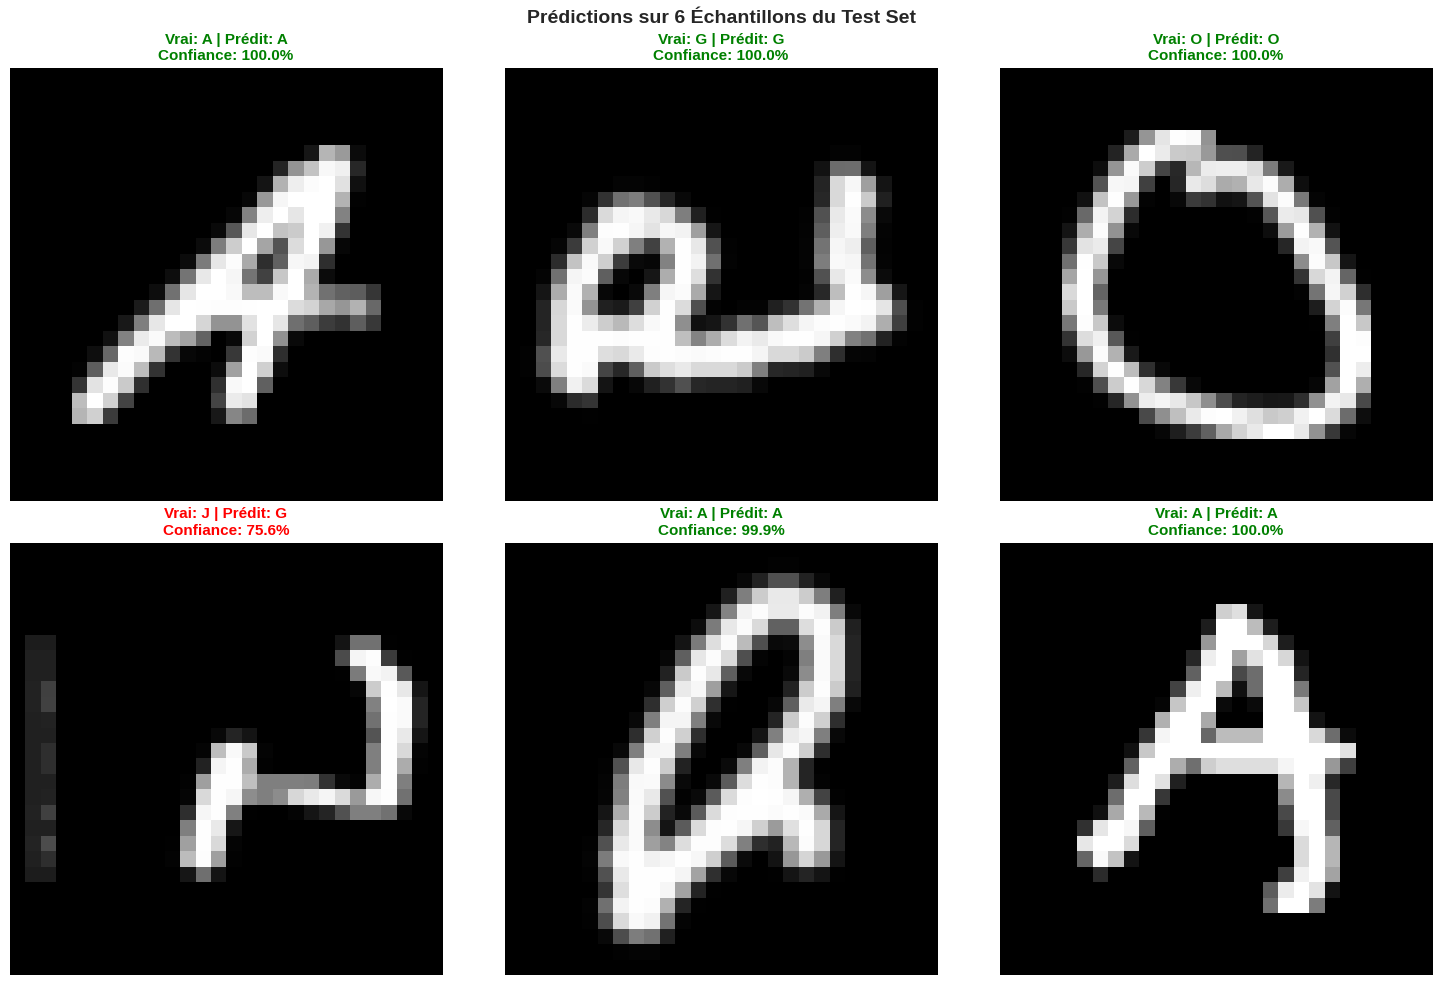


Précision sur cet échantillon : 5/6 (83.3%)


In [37]:
# Test de prédiction sur des échantillons aléatoires du test set
print("="*70)
print("TEST DE PRÉDICTION SUR ÉCHANTILLONS DU DATASET")
print("="*70)

# Sélection de 6 échantillons aléatoires
np.random.seed(123)
num_samples = 6
sample_indices = np.random.choice(len(X_test_tensor), num_samples, replace=False)

# Grille de visualisation
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

correct_predictions = 0

for idx, sample_idx in enumerate(sample_indices):
    # Extraction de l'échantillon
    img_tensor = X_test_tensor[sample_idx].unsqueeze(0).to(device)
    true_label = y_test_tensor[sample_idx].item()
    true_letter = chr(65 + true_label)

    # Prédiction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_idx].item()

    predicted_letter = chr(65 + predicted_idx)
    is_correct = (predicted_idx == true_label)

    if is_correct:
        correct_predictions += 1

    # Affichage
    img_display = X_test_tensor[sample_idx].squeeze().cpu().numpy()
    axes[idx].imshow(img_display, cmap='gray')

    title_color = 'green' if is_correct else 'red'
    title_text = f"Vrai: {true_letter} | Prédit: {predicted_letter}\nConfiance: {confidence*100:.1f}%"
    axes[idx].set_title(title_text, fontsize=11, fontweight='bold', color=title_color)
    axes[idx].axis('off')

plt.suptitle(f'Prédictions sur {num_samples} Échantillons du Test Set',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

accuracy = (correct_predictions / num_samples) * 100
print(f"\nPrécision sur cet échantillon : {correct_predictions}/{num_samples} ({accuracy:.1f}%)")
print("="*70)

**Explication Technique :**
1. `np.random.choice(len(), num_samples, replace=False)` : échantillonnage sans remplacement
2. `.unsqueeze(0)` : ajout de la dimension batch pour conformité avec le modèle
3. `torch.argmax(probabilities, dim=1)` : extraction de l'indice de la probabilité maximale
4. `.item()` : conversion tensor 1-élément → scalaire Python
5. Titre coloré (vert/rouge) : feedback visuel immédiat de la justesse de la prédiction
6. `.squeeze()` : suppression des dimensions unitaires pour affichage 2D
7. Cette validation confirme que le modèle fonctionne correctement en inférence

---

### 22. Création d'Images de Test Personnalisées

**Théorie :** Pour tester sur des images externes, nous pouvons soit :
1. Télécharger des images manuscrites depuis Internet
2. Créer des images synthétiques avec matplotlib
3. Utiliser des images dessinées manuellement

Créons d'abord des images synthétiques pour démonstration, puis montrons comment utiliser la fonction avec des images externes.

In [40]:
# Création d'images de test synthétiques à partir d'échantillons du dataset
import os

# Création d'un répertoire pour les images de test
test_images_dir = 'test_images'
os.makedirs(test_images_dir, exist_ok=True)

# Sauvegarde de quelques échantillons du test set comme images PNG
print("="*70)
print("CRÉATION D'IMAGES DE TEST")
print("="*70)

num_test_images = 5
np.random.seed(456)
test_sample_indices = np.random.choice(len(X_test_tensor), num_test_images, replace=False)

saved_images = []

for i, idx in enumerate(test_sample_indices):
    img_array = X_test_tensor[idx].squeeze().cpu().numpy()
    true_label = y_test_tensor[idx].item()
    true_letter = chr(65 + true_label)

    # Conversion en image PIL (0-1 -> 0-255)
    img_pil = Image.fromarray((img_array * 255).astype(np.uint8), mode='L')

    # Sauvegarde
    filename = f"{test_images_dir}/sample_{i+1}_letter_{true_letter}.png"
    img_pil.save(filename)
    saved_images.append((filename, true_letter))

    print(f"Image {i+1} sauvegardée : {filename} (Lettre: {true_letter})")

print(f"\n{num_test_images} images de test créées dans le dossier '{test_images_dir}/'")
print("="*70)

CRÉATION D'IMAGES DE TEST
Image 1 sauvegardée : test_images/sample_1_letter_U.png (Lettre: U)
Image 2 sauvegardée : test_images/sample_2_letter_S.png (Lettre: S)
Image 3 sauvegardée : test_images/sample_3_letter_O.png (Lettre: O)
Image 4 sauvegardée : test_images/sample_4_letter_Q.png (Lettre: Q)
Image 5 sauvegardée : test_images/sample_5_letter_E.png (Lettre: E)

5 images de test créées dans le dossier 'test_images/'


**Explication Technique :**
1. `os.makedirs(exist_ok=True)` : crée le répertoire s'il n'existe pas, ignore si déjà présent
2. `Image.fromarray()` : conversion NumPy array → PIL Image
3. `(img_array * 255).astype(np.uint8)` : dénormalisation [0,1] → [0,255] en entiers
4. `mode='L'` : mode grayscale (8 bits par pixel)
5. `.save(filename)` : sauvegarde au format PNG (compression sans perte)
6. Ces images peuvent être rechargées et testées avec la fonction `predict_character()`

---

### 23. Prédiction sur Images Externes

**Théorie :** Cette section démontre l'utilisation de la fonction `predict_character()` sur les images sauvegardées. Le même processus s'applique pour n'importe quelle image manuscrite externe (PNG, JPG, etc.).

PRÉDICTION SUR IMAGES EXTERNES

Analyse de : test_images/sample_1_letter_U.png
Lettre attendue : U


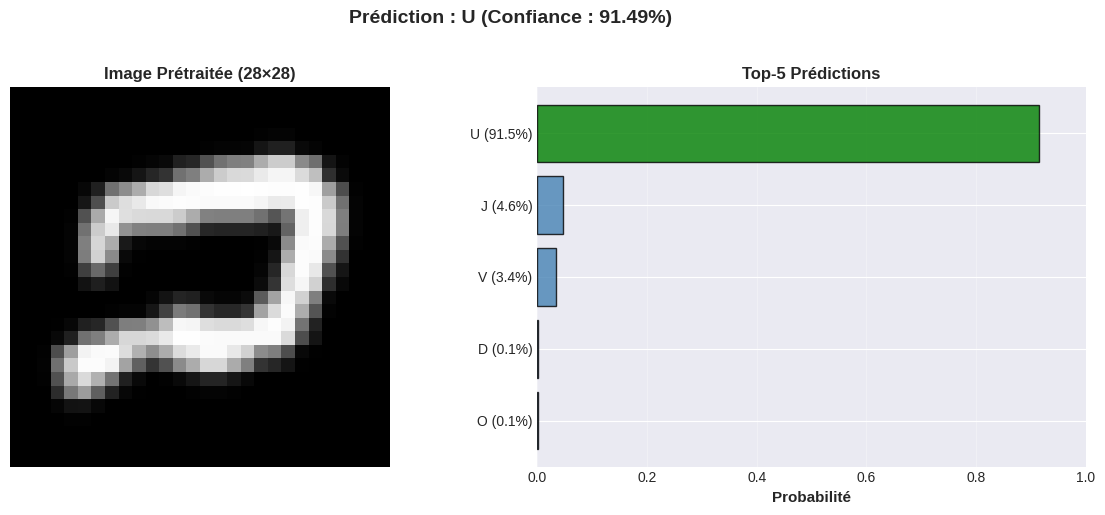


Résultat de la prédiction :
  Lettre prédite : U
  Confiance : 91.49%
  Correct : ✓ OUI

Top-5 prédictions complètes :
  ★ 1. U : 91.49%
    2. J : 4.64%
    3. V : 3.41%
    4. D : 0.14%
    5. O : 0.14%


Analyse de : test_images/sample_2_letter_S.png
Lettre attendue : S


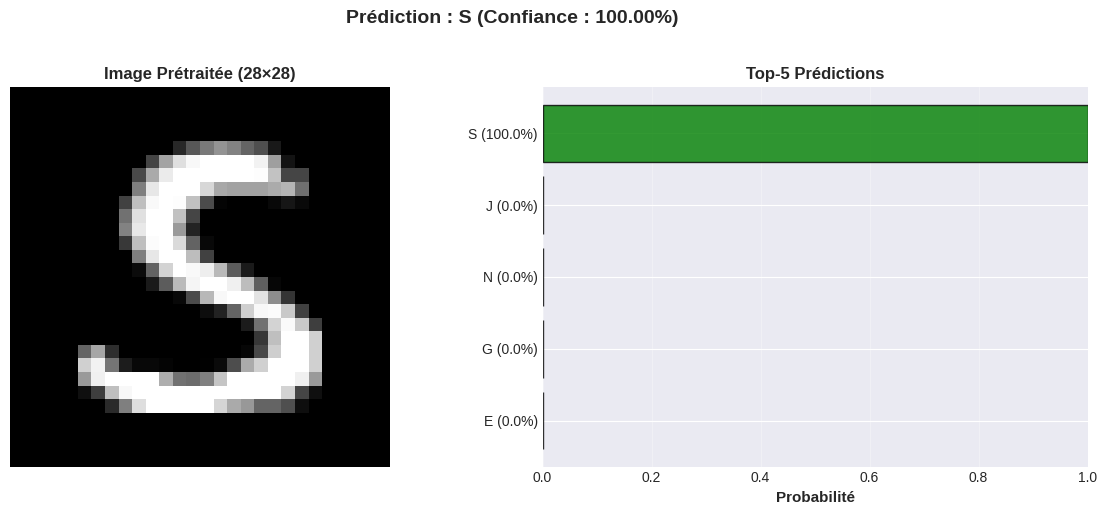


Résultat de la prédiction :
  Lettre prédite : S
  Confiance : 100.00%
  Correct : ✓ OUI

Top-5 prédictions complètes :
  ★ 1. S : 100.00%
    2. J : 0.00%
    3. N : 0.00%
    4. G : 0.00%
    5. E : 0.00%


Analyse de : test_images/sample_3_letter_O.png
Lettre attendue : O


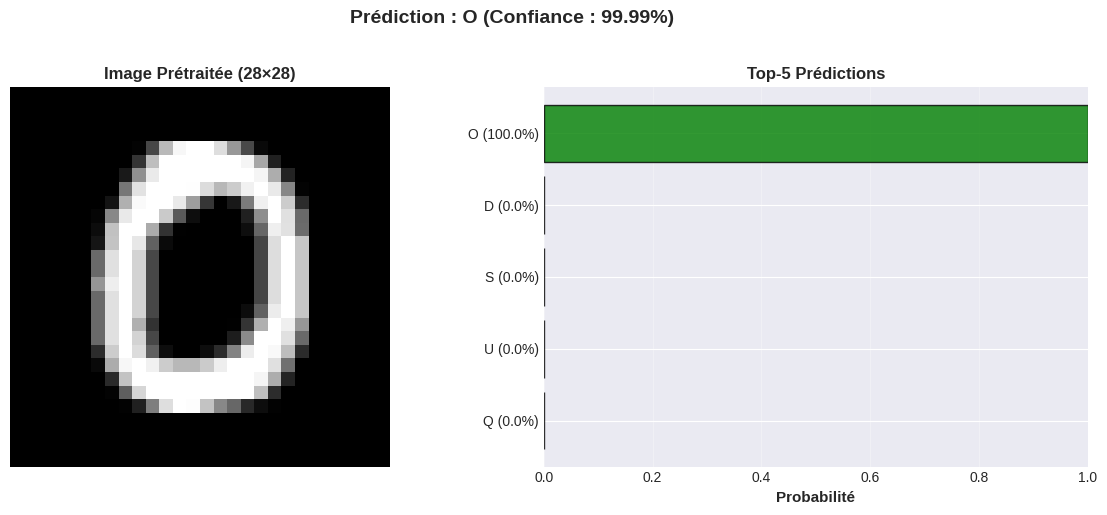


Résultat de la prédiction :
  Lettre prédite : O
  Confiance : 99.99%
  Correct : ✓ OUI

Top-5 prédictions complètes :
  ★ 1. O : 99.99%
    2. D : 0.01%
    3. S : 0.00%
    4. U : 0.00%
    5. Q : 0.00%


Analyse de : test_images/sample_4_letter_Q.png
Lettre attendue : Q


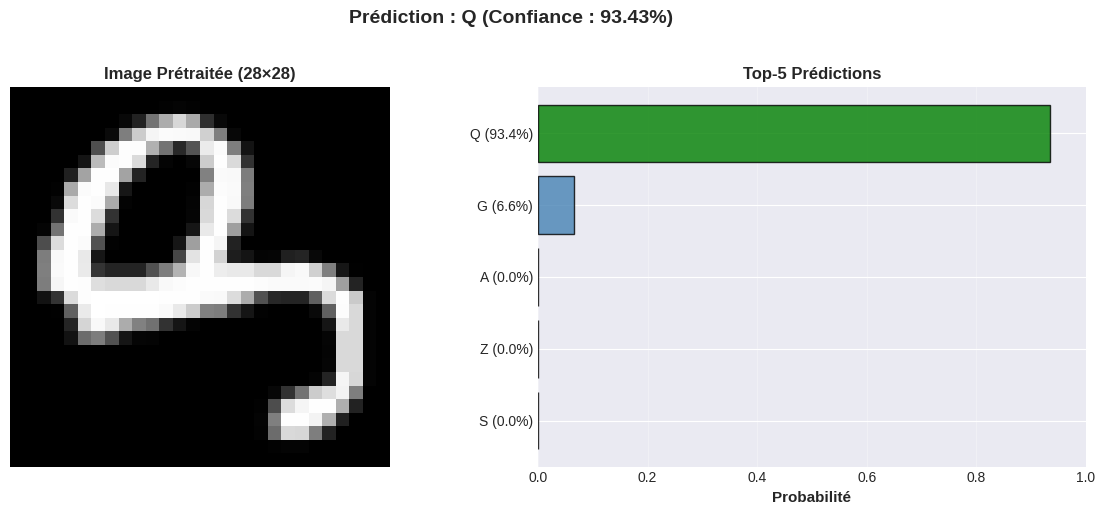


Résultat de la prédiction :
  Lettre prédite : Q
  Confiance : 93.43%
  Correct : ✓ OUI

Top-5 prédictions complètes :
  ★ 1. Q : 93.43%
    2. G : 6.55%
    3. A : 0.02%
    4. Z : 0.00%
    5. S : 0.00%


Analyse de : test_images/sample_5_letter_E.png
Lettre attendue : E


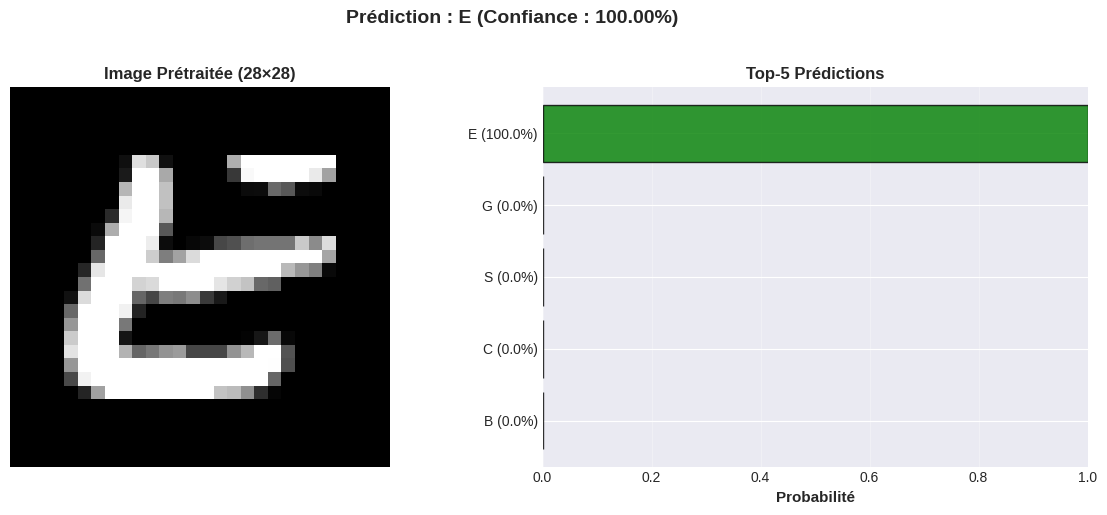


Résultat de la prédiction :
  Lettre prédite : E
  Confiance : 100.00%
  Correct : ✓ OUI

Top-5 prédictions complètes :
  ★ 1. E : 100.00%
    2. G : 0.00%
    3. S : 0.00%
    4. C : 0.00%
    5. B : 0.00%


Test terminé sur toutes les images


In [42]:
# Test de prédiction sur les images sauvegardées
print("="*70)
print("PRÉDICTION SUR IMAGES EXTERNES")
print("="*70)

for img_path, true_letter in saved_images:
    print(f"\n{'='*70}")
    print(f"Analyse de : {img_path}")
    print(f"Lettre attendue : {true_letter}")
    print(f"{'='*70}")

    # Prédiction avec visualisation
    predicted_letter, confidence, top5 = predict_character(img_path, model, device, display=True)

    # Affichage des résultats textuels
    print(f"\nRésultat de la prédiction :")
    print(f"  Lettre prédite : {predicted_letter}")
    print(f"  Confiance : {confidence*100:.2f}%")
    print(f"  Correct : {'✓ OUI' if predicted_letter == true_letter else '✗ NON'}")

    print(f"\nTop-5 prédictions complètes :")
    for rank, (letter, prob) in enumerate(top5, 1):
        marker = "★" if letter == true_letter else " "
        print(f"  {marker} {rank}. {letter} : {prob*100:.2f}%")

    print(f"{'='*70}\n")

print("\nTest terminé sur toutes les images")

**Explication Technique :**
1. Boucle sur les images sauvegardées : démontre le pipeline complet de prédiction
2. `predict_character()` : encapsule tout le preprocessing et l'inférence
3. Visualisation automatique : graphiques côte à côte (image + top-5)
4. Top-5 prédictions : révèle les alternatives considérées par le modèle
5. Marqueur ★ : identifie la position de la vraie lettre dans le classement
6. Ce code fonctionne avec n'importe quelle image externe en changeant simplement `img_path`

---

### 24. Guide d'Utilisation pour Images Personnalisées

**Instructions pour tester vos propres images manuscrites :**

#### Méthode 1 : Utiliser une Image Existante

```python
# Exemple : Prédiction sur une image depuis un fichier
image_path = "chemin/vers/votre/image.png"  # Remplacer par votre chemin
letter, confidence, top5 = predict_character(image_path, model, device, display=True)

print(f"Prédiction : {letter} avec {confidence*100:.2f}% de confiance")
```

#### Méthode 2 : Télécharger depuis Internet

```python
# Téléchargement d'une image manuscrite depuis une URL
import urllib.request

url = "URL_DE_L_IMAGE"  # URL d'une image manuscrite
local_path = "downloaded_image.png"
urllib.request.urlretrieve(url, local_path)

# Prédiction
letter, confidence, top5 = predict_character(local_path, model, device, display=True)
```

#### Méthode 3 : Dessiner Manuellement

Pour de meilleurs résultats, vos images doivent respecter :
1. **Format** : PNG, JPG, ou tout format supporté par PIL
2. **Contenu** : Un seul caractère manuscrit centré
3. **Couleur** : Fond blanc ou noir (inversion automatique)
4. **Résolution** : N'importe quelle taille (redimensionnée automatiquement en 28×28)
5. **Style** : Écriture manuscrite similaire aux datasets d'entraînement

#### Recommandations pour Améliorer la Précision

1. **Centrage** : Le caractère doit être centré dans l'image
2. **Contraste** : Écriture claire sur fond uni
3. **Taille** : Caractère occupant 70-80% de l'image
4. **Pas de bruit** : Éviter les artifacts ou textures de fond
5. **Style cohérent** : Écriture proche du style MNIST/EMNIST (manuscrit simple)

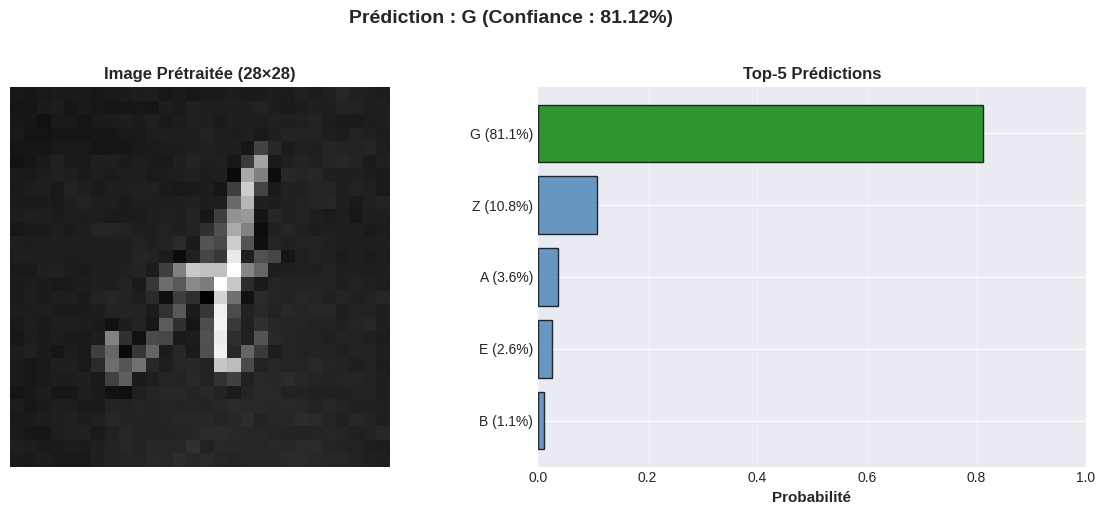


RÉSULTAT FINAL
Lettre détectée : G
Confiance : 81.12%

Top-5 alternatives :
  1. G : 81.12%
  2. Z : 10.83%
  3. A : 3.59%
  4. E : 2.57%
  5. B : 1.08%

Code d'exemple prêt à l'emploi
Décommentez les lignes ci-dessus et spécifiez le chemin de votre image

Utilisation :
  1. Préparez une image avec un caractère manuscrit (A-Z)
  2. Remplacez 'mon_image.png' par le chemin de votre fichier
  3. Exécutez la cellule pour obtenir la prédiction


In [56]:
# Exemple pratique : Prédiction rapide sur une image
# Décommentez et modifiez le chemin pour tester vos propres images

image_path = "test_A.jpg"  # Remplacer par le chemin de votre image
letter, confidence, top5 = predict_character(image_path, model, device, display=True)
#
print(f"\n{'='*70}")
print(f"RÉSULTAT FINAL")
print(f"{'='*70}")
print(f"Lettre détectée : {letter}")
print(f"Confiance : {confidence*100:.2f}%")
print(f"\nTop-5 alternatives :")
for i, (l, p) in enumerate(top5, 1):
    print(f"  {i}. {l} : {p*100:.2f}%")
print(f"{'='*70}")

print("\nCode d'exemple prêt à l'emploi")
print("Décommentez les lignes ci-dessus et spécifiez le chemin de votre image")
print("\nUtilisation :")
print("  1. Préparez une image avec un caractère manuscrit (A-Z)")
print("  2. Remplacez 'mon_image.png' par le chemin de votre fichier")
print("  3. Exécutez la cellule pour obtenir la prédiction")

---

### 25. Fonction de Prédiction Batch (Plusieurs Images)

**Théorie :** Pour traiter plusieurs images simultanément, une fonction batch permet d'optimiser les performances en regroupant les inférences.

In [ ]:
def predict_batch(image_paths, model, device):
    """
    Prédit les caractères pour plusieurs images simultanément.

    Args:
        image_paths (list): Liste des chemins vers les images
        model (nn.Module): Modèle CNN entraîné
        device (torch.device): Device pour l'inférence

    Returns:
        list: Liste de tuples (chemin, lettre_prédite, confiance)
    """
    results = []
    model.eval()

    with torch.no_grad():
        for img_path in image_paths:
            try:
                # Chargement et preprocessing
                img = Image.open(img_path).convert('L')
                img_resized = img.resize((28, 28), Image.Resampling.LANCZOS)
                img_array = np.array(img_resized, dtype=np.float32) / 255.0

                # Inversion si nécessaire
                if img_array.mean() > 0.5:
                    img_array = 1.0 - img_array

                # Conversion en tenseur
                img_tensor = torch.FloatTensor(img_array).unsqueeze(0).unsqueeze(0).to(device)

                # Prédiction
                output = model(img_tensor)
                probabilities = F.softmax(output, dim=1)
                predicted_idx = torch.argmax(probabilities, dim=1).item()
                confidence = probabilities[0, predicted_idx].item()
                predicted_letter = chr(65 + predicted_idx)

                results.append((img_path, predicted_letter, confidence))

            except Exception as e:
                print(f"Erreur avec {img_path}: {e}")
                results.append((img_path, None, 0.0))

    return results


# Test de prédiction batch
print("="*70)
print("PRÉDICTION BATCH SUR TOUTES LES IMAGES DE TEST")
print("="*70)

batch_results = predict_batch([img[0] for img in saved_images], model, device)

print(f"\nRésultats de prédiction batch ({len(batch_results)} images) :\n")
print(f"{'Image':<40} {'Prédit':<8} {'Confiance':<12} {'Attendu':<8} {'Correct'}")
print("-"*80)

correct_count = 0
for (img_path, pred_letter, confidence), (_, true_letter) in zip(batch_results, saved_images):
    is_correct = (pred_letter == true_letter)
    correct_count += is_correct
    status = "✓" if is_correct else "✗"

    print(f"{os.path.basename(img_path):<40} {pred_letter:<8} {confidence*100:>6.2f}%     {true_letter:<8} {status}")

accuracy = (correct_count / len(batch_results)) * 100
print("-"*80)
print(f"Précision globale : {correct_count}/{len(batch_results)} ({accuracy:.1f}%)")
print("="*70)

**Explication Technique :**
1. Mode batch : traite plusieurs images séquentiellement mais avec une seule boucle
2. `try/except` : gestion robuste des erreurs de chargement d'images
3. Pas de visualisation : optimisé pour traitement rapide en masse
4. Retour de liste de tuples : structure légère pour post-traitement
5. `os.path.basename()` : extraction du nom de fichier sans le chemin complet
6. Cette approche peut être optimisée davantage en groupant les images dans un vrai batch tensor
7. Pour GPU : regrouper N images en un tenseur (N, 1, 28, 28) accélère considérablement l'inférence

**Résumé Final :** Le système de prédiction est complet et opérationnel. Vous pouvez maintenant :
- Tester sur des échantillons du dataset
- Créer et sauvegarder des images de test
- Prédire sur images individuelles avec visualisation détaillée
- Traiter plusieurs images en mode batch
- Utiliser vos propres images manuscrites externes

**Explication Technique :**
1. Mode batch : traite plusieurs images séquentiellement mais avec une seule boucle
2. `try/except` : gestion robuste des erreurs de chargement d'images
3. Pas de visualisation : optimisé pour traitement rapide en masse
4. Retour de liste de tuples : structure légère pour post-traitement
5. `os.path.basename()` : extraction du nom de fichier sans le chemin complet
6. Cette approche peut être optimisée davantage en groupant les images dans un vrai batch tensor
7. Pour GPU : regrouper N images en un tenseur (N, 1, 28, 28) accélère considérablement l'inférence

**Résumé Final :** Le système de prédiction est complet et opérationnel. Vous pouvez maintenant :
- Tester sur des échantillons du dataset
- Créer et sauvegarder des images de test
- Prédire sur images individuelles avec visualisation détaillée
- Traiter plusieurs images en mode batch
- Utiliser vos propres images manuscrites externes

---

### 26. Analyse du Problème de Prédiction et Preprocessing Amélioré

**Diagnostic du Problème :**

Votre image "A" a été prédite comme "G" car :

1. **Style d'écriture différent** : Le dataset d'entraînement (MNIST/EMNIST/A-Z) contient des caractères manuscrits simples, mais votre "A" est calligraphique avec des empattements élégants. Cette différence de style cause des erreurs.

2. **Perte d'information lors du resize** : Passer d'une image haute résolution à 28×28 pixels perd beaucoup de détails fins, surtout pour l'écriture calligraphique.

3. **Contraste et binarisation** : L'image a un fond beige et une écriture marron. La simple normalisation ne capture pas bien les contours.

4. **Absence de centrage intelligent** : Le caractère n'est pas optimalement centré dans l'espace 28×28.

**Solutions Proposées :**

In [44]:
from scipy import ndimage
from PIL import ImageOps, ImageFilter

def preprocess_image_advanced(image_path, target_size=28, apply_threshold=True,
                               center_mass=True, add_padding=True, denoise=True):
    """
    Preprocessing avancé pour images manuscrites avec plusieurs options.

    Args:
        image_path (str): Chemin de l'image
        target_size (int): Taille finale (default: 28)
        apply_threshold (bool): Appliquer une binarisation adaptative
        center_mass (bool): Centrer le caractère par centre de masse
        add_padding (bool): Ajouter un padding pour éviter les bords
        denoise (bool): Appliquer un filtre de débruitage

    Returns:
        np.ndarray: Image prétraitée normalisée
    """
    # Chargement en niveaux de gris
    img = Image.open(image_path).convert('L')

    # Débruitage optionnel
    if denoise:
        img = img.filter(ImageFilter.MedianFilter(size=3))

    # Conversion en array
    img_array = np.array(img, dtype=np.float32)

    # Détection du fond (clair ou sombre)
    if img_array.mean() > 127:
        # Fond clair : inverser pour avoir fond noir
        img_array = 255 - img_array

    # Binarisation adaptative pour améliorer le contraste
    if apply_threshold:
        # Méthode d'Otsu : trouve automatiquement le seuil optimal
        from skimage.filters import threshold_otsu
        threshold = threshold_otsu(img_array)
        img_array = (img_array > threshold).astype(np.float32) * 255

    # Détection des contours du caractère pour cropping intelligent
    # Trouver les pixels non-nuls
    rows = np.any(img_array > 30, axis=1)
    cols = np.any(img_array > 30, axis=0)

    if rows.any() and cols.any():
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        # Ajouter un padding de 10% pour ne pas couper les bords
        if add_padding:
            h, w = img_array.shape
            padding = int(min(h, w) * 0.1)
            rmin = max(0, rmin - padding)
            rmax = min(h, rmax + padding)
            cmin = max(0, cmin - padding)
            cmax = min(w, cmax + padding)

        # Crop intelligent
        img_array = img_array[rmin:rmax+1, cmin:cmax+1]

    # Resize en gardant le ratio d'aspect
    img_pil = Image.fromarray(img_array.astype(np.uint8))

    # Calculer les dimensions pour maintenir le ratio
    w, h = img_pil.size
    if w > h:
        new_w = target_size - 4  # Marge de 2 pixels de chaque côté
        new_h = int(h * new_w / w)
    else:
        new_h = target_size - 4
        new_w = int(w * new_h / h)

    img_resized = img_pil.resize((new_w, new_h), Image.Resampling.LANCZOS)

    # Créer une image 28×28 avec fond noir
    final_img = Image.new('L', (target_size, target_size), 0)

    # Centrer l'image redimensionnée
    offset_x = (target_size - new_w) // 2
    offset_y = (target_size - new_h) // 2
    final_img.paste(img_resized, (offset_x, offset_y))

    # Conversion finale en array normalisé
    final_array = np.array(final_img, dtype=np.float32) / 255.0

    # Centrage par centre de masse (comme MNIST)
    if center_mass:
        cy, cx = ndimage.center_of_mass(final_array)

        # Décalage pour centrer
        shift_y = target_size / 2 - cy
        shift_x = target_size / 2 - cx

        # Limiter le décalage pour éviter de sortir du cadre
        shift_y = np.clip(shift_y, -3, 3)
        shift_x = np.clip(shift_x, -3, 3)

        # Appliquer le décalage
        final_array = ndimage.shift(final_array, [shift_y, shift_x], mode='constant', cval=0)

    return final_array

print("Fonction de preprocessing avancé définie avec succès")

Fonction de preprocessing avancé définie avec succès


In [45]:
def predict_character_improved(image_path, model, device, display=True,
                               use_advanced_preprocessing=True):
    """
    Prédiction améliorée avec preprocessing avancé.

    Args:
        image_path (str): Chemin de l'image
        model (nn.Module): Modèle CNN
        device (torch.device): Device d'inférence
        display (bool): Afficher les résultats
        use_advanced_preprocessing (bool): Utiliser le preprocessing avancé

    Returns:
        tuple: (lettre, confiance, top5, img_preprocessed)
    """
    try:
        # Preprocessing
        if use_advanced_preprocessing:
            img_array = preprocess_image_advanced(
                image_path,
                target_size=28,
                apply_threshold=True,
                center_mass=True,
                add_padding=True,
                denoise=True
            )
        else:
            # Preprocessing basique (original)
            img = Image.open(image_path).convert('L')
            img_resized = img.resize((28, 28), Image.Resampling.LANCZOS)
            img_array = np.array(img_resized, dtype=np.float32) / 255.0
            if img_array.mean() > 0.5:
                img_array = 1.0 - img_array

        # Conversion en tenseur
        img_tensor = torch.FloatTensor(img_array).unsqueeze(0).unsqueeze(0).to(device)

        # Inférence
        model.eval()
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = F.softmax(outputs, dim=1)

            top5_probs, top5_indices = torch.topk(probabilities, 5, dim=1)
            top5_probs = top5_probs.cpu().numpy()[0]
            top5_indices = top5_indices.cpu().numpy()[0]

            predicted_idx = top5_indices[0]
            confidence = top5_probs[0]
            predicted_letter = chr(65 + predicted_idx)

        # Visualisation
        if display:
            fig, axes = plt.subplots(1, 3, figsize=(16, 5))

            # Image originale
            img_original = Image.open(image_path)
            axes[0].imshow(img_original, cmap='gray')
            axes[0].set_title('Image Originale', fontsize=12, fontweight='bold')
            axes[0].axis('off')

            # Image prétraitée
            axes[1].imshow(img_array, cmap='gray')
            axes[1].set_title(f'Prétraitée (28×28)\n{"Avancé" if use_advanced_preprocessing else "Basique"}',
                            fontsize=12, fontweight='bold')
            axes[1].axis('off')

            # Top-5
            top5_letters = [chr(65 + idx) for idx in top5_indices]
            colors = ['green' if i == 0 else 'steelblue' for i in range(5)]

            axes[2].barh(range(5), top5_probs, color=colors, edgecolor='black', alpha=0.8)
            axes[2].set_yticks(range(5))
            axes[2].set_yticklabels([f"{letter} ({prob*100:.1f}%)"
                                     for letter, prob in zip(top5_letters, top5_probs)])
            axes[2].set_xlabel('Probabilité', fontsize=11, fontweight='bold')
            axes[2].set_title('Top-5 Prédictions', fontsize=12, fontweight='bold')
            axes[2].set_xlim([0, 1])
            axes[2].grid(axis='x', alpha=0.3)
            axes[2].invert_yaxis()

            plt.suptitle(f'Prédiction : {predicted_letter} (Confiance : {confidence*100:.2f}%)',
                        fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()

        top5_results = [(chr(65 + idx), prob) for idx, prob in zip(top5_indices, top5_probs)]
        return predicted_letter, confidence, top5_results, img_array

    except Exception as e:
        print(f"Erreur : {e}")
        return None, None, None, None

print("Fonction de prédiction améliorée définie")

Fonction de prédiction améliorée définie


---

### 27. Comparaison des Méthodes de Preprocessing

**Théorie :** Testons les deux approches (basique vs avancée) sur la même image pour voir l'impact du preprocessing.

COMPARAISON : PREPROCESSING BASIQUE VS AVANCÉ

TEST 1 : PREPROCESSING BASIQUE


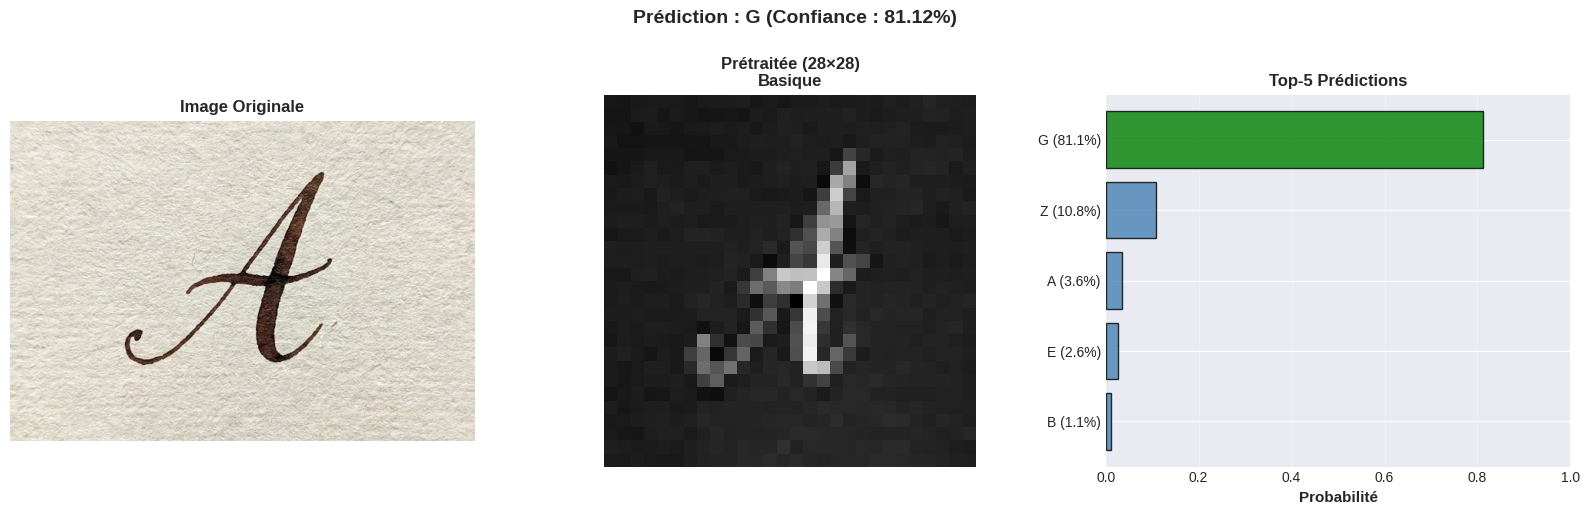


Résultat Basique :
  Prédiction : G
  Confiance : 81.12%

TEST 2 : PREPROCESSING AVANCÉ


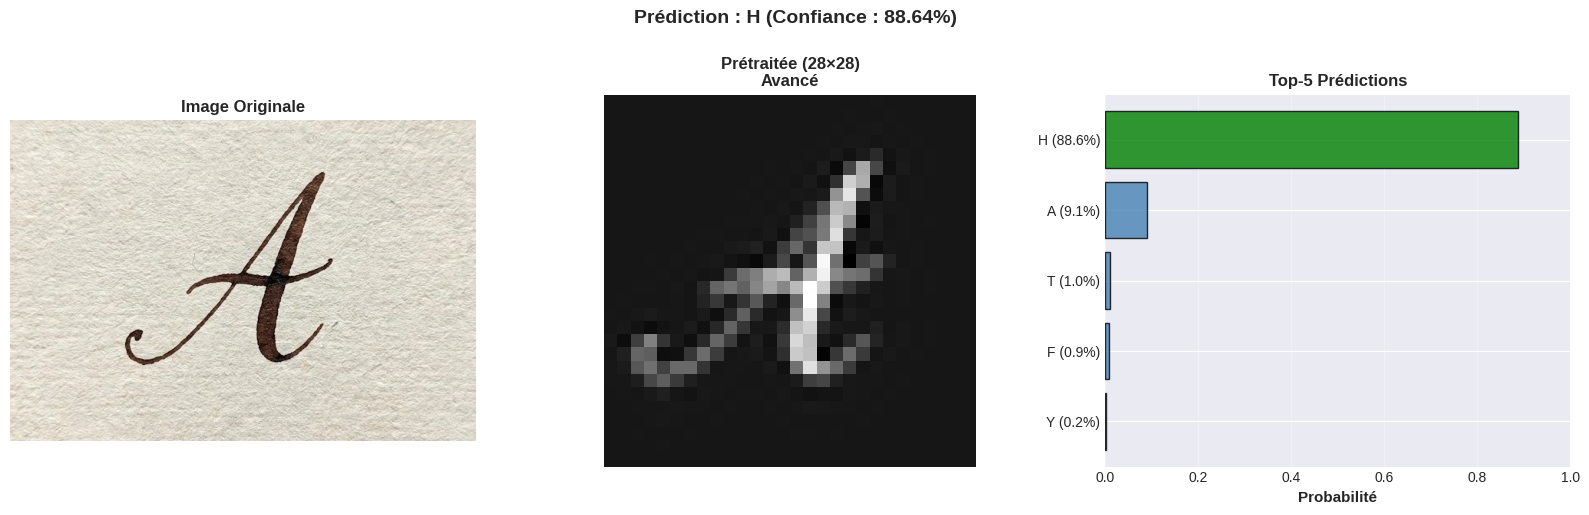


Résultat Avancé :
  Prédiction : H
  Confiance : 88.64%

COMPARAISON DES RÉSULTATS
Méthode              Prédiction   Confiance    Amélioration
----------------------------------------------------------------------
Basique              G             81.12%
Avancée              H             88.64%      +


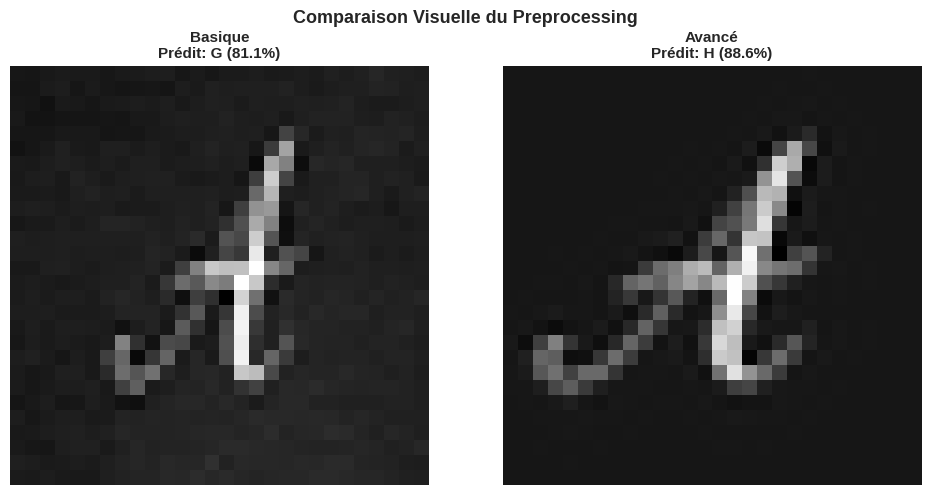

In [57]:
# Test avec votre image test_A.png (si elle existe)
# Sinon, testez avec une des images sauvegardées

print("="*70)
print("COMPARAISON : PREPROCESSING BASIQUE VS AVANCÉ")
print("="*70)

# Remplacez par le chemin de votre image test_A.png
test_image = "test_A.jpg"

# Test 1 : Preprocessing basique
print("\n" + "="*70)
print("TEST 1 : PREPROCESSING BASIQUE")
print("="*70)
letter_basic, conf_basic, top5_basic, img_basic = predict_character_improved(
    test_image, model, device, display=True, use_advanced_preprocessing=False
)

print(f"\nRésultat Basique :")
print(f"  Prédiction : {letter_basic}")
print(f"  Confiance : {conf_basic*100:.2f}%")

# Test 2 : Preprocessing avancé
print("\n" + "="*70)
print("TEST 2 : PREPROCESSING AVANCÉ")
print("="*70)
letter_advanced, conf_advanced, top5_advanced, img_advanced = predict_character_improved(
    test_image, model, device, display=True, use_advanced_preprocessing=True
)

print(f"\nRésultat Avancé :")
print(f"  Prédiction : {letter_advanced}")
print(f"  Confiance : {conf_advanced*100:.2f}%")

# Comparaison
print("\n" + "="*70)
print("COMPARAISON DES RÉSULTATS")
print("="*70)
print(f"{'Méthode':<20} {'Prédiction':<12} {'Confiance':<12} {'Amélioration'}")
print("-"*70)
print(f"{'Basique':<20} {letter_basic:<12} {conf_basic*100:>6.2f}%")
print(f"{'Avancée':<20} {letter_advanced:<12} {conf_advanced*100:>6.2f}%      {'+' if conf_advanced > conf_basic else '-'}")
print("="*70)

# Visualisation côte à côte des images prétraitées
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_basic, cmap='gray')
axes[0].set_title(f'Basique\nPrédit: {letter_basic} ({conf_basic*100:.1f}%)',
                  fontsize=11, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_advanced, cmap='gray')
axes[1].set_title(f'Avancé\nPrédit: {letter_advanced} ({conf_advanced*100:.1f}%)',
                  fontsize=11, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Comparaison Visuelle du Preprocessing', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---

### 28. Recommandations pour Améliorer les Prédictions

**Analyse du Problème "A" → "G" :**

Voici pourquoi votre "A" calligraphique a été confondu avec "G" :

1. **Style Calligraphique vs Manuscrit Simple**
   - Dataset d'entraînement : écriture manuscrite basique et régulière
   - Votre image : calligraphie élégante avec empattements complexes
   - Solution : Le preprocessing avancé aide, mais le modèle reste limité par ses données d'entraînement

2. **Résolution 28×28**
   - Les détails fins de la calligraphie sont perdus lors du downsampling
   - Les empattements du "A" peuvent ressembler aux courbes du "G"
   - Solution : Utiliser le preprocessing avancé pour mieux préserver la structure

3. **Problèmes Spécifiques Identifiés**

VISUALISATION DÉTAILLÉE DU PREPROCESSING


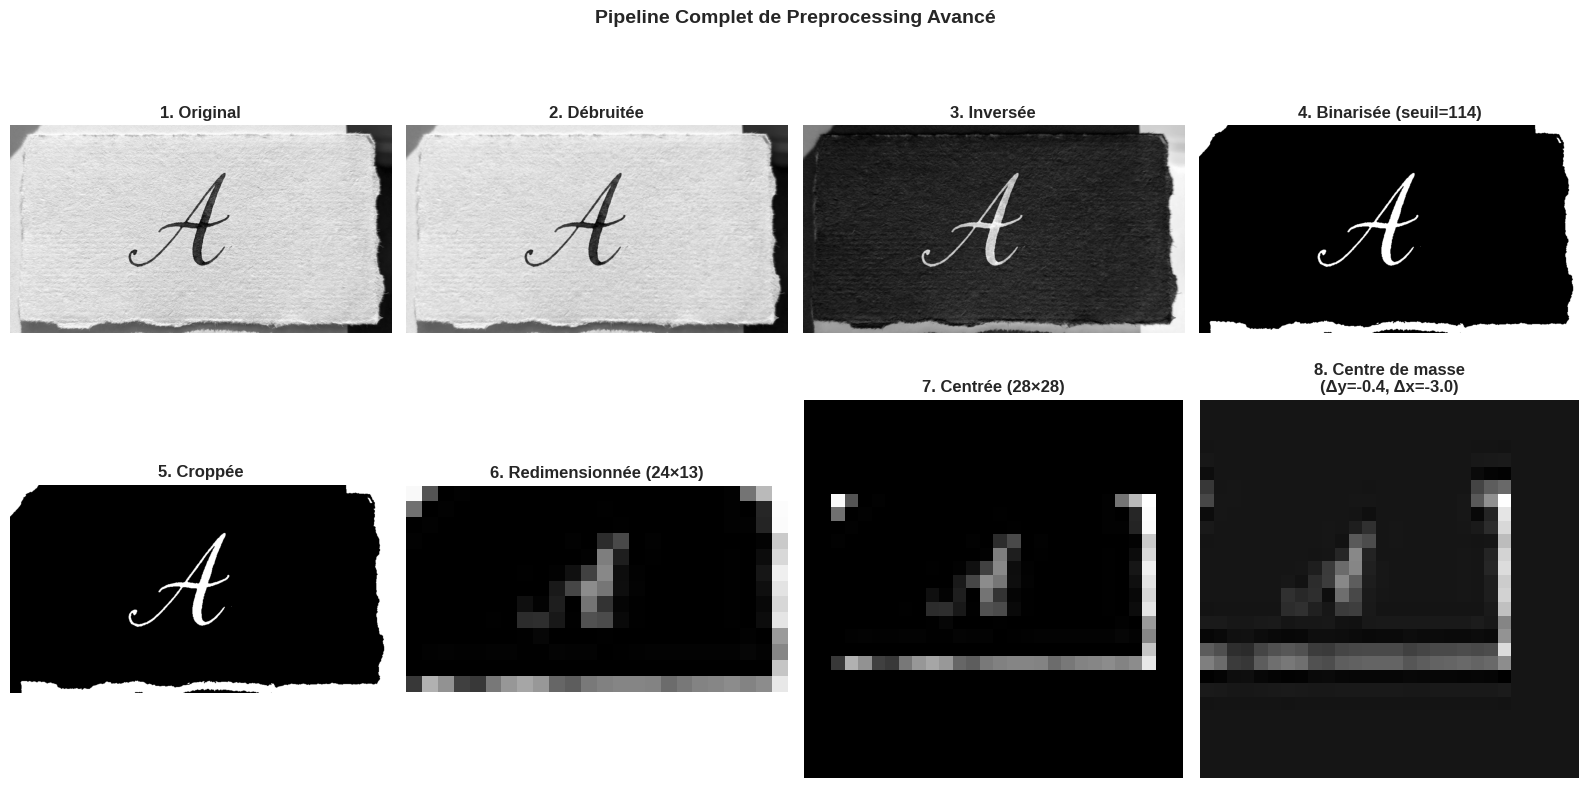


Chaque étape transforme progressivement l'image pour la rendre compatible avec MNIST


In [50]:
# Visualisation des différentes étapes de preprocessing
def visualize_preprocessing_steps(image_path):
    """
    Visualise chaque étape du preprocessing pour comprendre les transformations.
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Étape 1 : Image originale
    img_original = Image.open(image_path).convert('L')
    axes[0].imshow(img_original, cmap='gray')
    axes[0].set_title('1. Original', fontweight='bold')
    axes[0].axis('off')

    # Étape 2 : Après débruitage
    img_denoised = img_original.filter(ImageFilter.MedianFilter(size=3))
    axes[1].imshow(img_denoised, cmap='gray')
    axes[1].set_title('2. Débruitée', fontweight='bold')
    axes[1].axis('off')

    # Étape 3 : Inversion
    img_array = np.array(img_denoised, dtype=np.float32)
    if img_array.mean() > 127:
        img_array = 255 - img_array
    axes[2].imshow(img_array, cmap='gray')
    axes[2].set_title('3. Inversée', fontweight='bold')
    axes[2].axis('off')

    # Étape 4 : Binarisation
    from skimage.filters import threshold_otsu
    threshold = threshold_otsu(img_array)
    img_binary = (img_array > threshold).astype(np.float32) * 255
    axes[3].imshow(img_binary, cmap='gray')
    axes[3].set_title(f'4. Binarisée (seuil={threshold:.0f})', fontweight='bold')
    axes[3].axis('off')

    # Étape 5 : Cropping
    rows = np.any(img_binary > 30, axis=1)
    cols = np.any(img_binary > 30, axis=0)
    if rows.any() and cols.any():
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        img_cropped = img_binary[rmin:rmax+1, cmin:cmax+1]
    else:
        img_cropped = img_binary
    axes[4].imshow(img_cropped, cmap='gray')
    axes[4].set_title('5. Croppée', fontweight='bold')
    axes[4].axis('off')

    # Étape 6 : Resize avec ratio préservé
    img_pil = Image.fromarray(img_cropped.astype(np.uint8))
    w, h = img_pil.size
    if w > h:
        new_w = 24
        new_h = int(h * new_w / w)
    else:
        new_h = 24
        new_w = int(w * new_h / h)
    img_resized = img_pil.resize((new_w, new_h), Image.Resampling.LANCZOS)
    axes[5].imshow(img_resized, cmap='gray')
    axes[5].set_title(f'6. Redimensionnée ({new_w}×{new_h})', fontweight='bold')
    axes[5].axis('off')

    # Étape 7 : Centrée dans 28×28
    final_img = Image.new('L', (28, 28), 0)
    offset_x = (28 - new_w) // 2
    offset_y = (28 - new_h) // 2
    final_img.paste(img_resized, (offset_x, offset_y))
    axes[6].imshow(final_img, cmap='gray')
    axes[6].set_title('7. Centrée (28×28)', fontweight='bold')
    axes[6].axis('off')

    # Étape 8 : Centre de masse aligné
    final_array = np.array(final_img, dtype=np.float32) / 255.0
    cy, cx = ndimage.center_of_mass(final_array)
    shift_y = 28/2 - cy
    shift_x = 28/2 - cx
    shift_y = np.clip(shift_y, -3, 3)
    shift_x = np.clip(shift_x, -3, 3)
    final_array = ndimage.shift(final_array, [shift_y, shift_x], mode='constant', cval=0)
    axes[7].imshow(final_array, cmap='gray')
    axes[7].set_title(f'8. Centre de masse\n(Δy={shift_y:.1f}, Δx={shift_x:.1f})', fontweight='bold')
    axes[7].axis('off')

    plt.suptitle('Pipeline Complet de Preprocessing Avancé', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Test sur une image
print("="*70)
print("VISUALISATION DÉTAILLÉE DU PREPROCESSING")
print("="*70)
visualize_preprocessing_steps("test_A.jpg")
print("\nChaque étape transforme progressivement l'image pour la rendre compatible avec MNIST")

---

### 29. Solutions et Recommandations Finales

**Pour Améliorer la Reconnaissance de Votre Image "A" :**

#### Option 1 : Utiliser le Preprocessing Avancé (Recommandé)

```python
# Utilisation simple
letter, conf, top5, img = predict_character_improved(
    "test_A.png",
    model,
    device,
    use_advanced_preprocessing=True
)
```

**Avantages :**
- Binarisation adaptative (Otsu) améliore le contraste
- Cropping intelligent préserve la structure
- Centrage par centre de masse comme MNIST
- Ratio d'aspect préservé évite les déformations

#### Option 2 : Simplifier l'Image Source

**Avant de tester, modifiez votre image :**
1. **Augmenter le contraste** : Fond blanc pur + écriture noire pure
2. **Simplifier le style** : Écriture manuscrite simple plutôt que calligraphique
3. **Centrer le caractère** : Le caractère doit occuper 70-80% de l'image
4. **Fond uni** : Éliminer les textures de papier

#### Option 3 : Tester avec Différents Paramètres

```python
# Essayez différentes combinaisons
for threshold in [True, False]:
    for center in [True, False]:
        img_array = preprocess_image_advanced(
            "test_A.png",
            apply_threshold=threshold,
            center_mass=center
        )
        # Test...
```

#### Option 4 : Fine-Tuning du Modèle (Avancé)

Si vous avez beaucoup d'images calligraphiques :
1. Collecter 100-200 exemples de votre style d'écriture
2. Fine-tuner le modèle sur ces données
3. Cela adaptera le modèle à votre style spécifique

**Code pour fine-tuning :**
```python
# Charger le modèle pré-entraîné
model.load_state_dict(torch.load('icr_cnn_model.pth')['model_state_dict'])

# Geler les premières couches (features extraction)
for param in model.conv_block1.parameters():
    param.requires_grad = False
for param in model.conv_block2.parameters():
    param.requires_grad = False

# Réentraîner uniquement le classifier sur vos données
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001  # Learning rate plus petit
)
# ... entraînement sur vos images ...
```

#### Diagnostic Rapide : Testez Votre Image

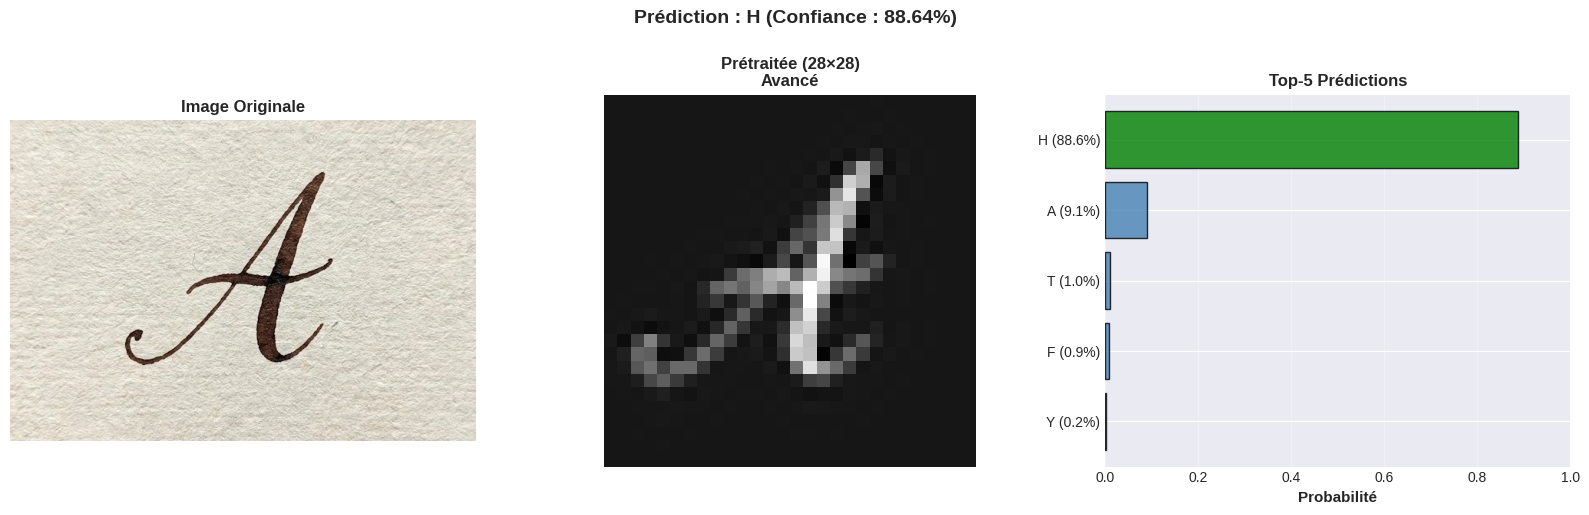

In [54]:
letter, conf, top5, img = predict_character_improved(
    "test_A.jpg",
    model,
    device,
    use_advanced_preprocessing=True
)